In [9]:
import os
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import cv2
import glob
import pandas as pd
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from matplotlib import gridspec
from scipy.signal import correlate, correlation_lags
from scipy.stats import pearsonr
from pathlib import Path
from tqdm import tqdm
from itertools import groupby
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}

plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Mass analysis module!
Here all generated csv sheet will be read, and assembled in to two giant pandas dataframes: videos and hyphae.

There are two datasheets that will be read:

    - Datasheets that pertain to the properties of the videos
    - Datasheets that contain the averaged results of the data
Ideally, the first datasheet will be generated by thev VideoInfo.txt files that Morrison outputs, but there are still a lot of videos that were made before Morrison was fully operational. Later on, this document will also be able to read the TIFFs of individual hyphae to create more data.

The first question to ask: Where is the analysis data stored? 

In [2]:
directory_target = "/gpfs/scratch1/shared/amftrackflow/Rachael_set/"

## Initial reading
This is where the video properties will be read from the excel files. It is called an initial reading, as this is just the raw data, which will be processed into a more legible datasheet in the next block. 

In [3]:
target_excels = sorted(glob.glob(directory_target + "**/*.x*"))
ini_read = pd.read_excel(target_excels[0], nrows=0)

for file in target_excels:
    read = pd.read_excel(file)
    ini_read = pd.concat([ini_read, read], ignore_index=True)

ini_read = ini_read.drop(ini_read[ini_read['Magnification'].isnull()].index)
ini_read

Unnamed: 0 Treatment Strain Time after crossing  \
2    20221026_plate452_01  1%P100&N     C2             10 days   
3    20221026_plate452_02  1%P100&N     C2             10 days   
4    20221026_plate452_03  1%P100&N     C2             10 days   
5    20221026_plate452_04  1%P100&N     C2             10 days   
6    20221026_plate452_05  1%P100&N     C2             10 days   
..                    ...       ...    ...                 ...   
953  20230201_Plate558_37  1%P100%N     C2             23 days   
954  20230201_Plate558_38  1%P100%N     C2             23 days   
956  20230201_Plate558_39  1%P100%N     C2             23 days   
957  20230201_Plate558_40  1%P100%N     C2             23 days   
958  20230201_Plate558_41  1%P100%N     C2             23 days   

     Growing temperature Position mm Unnamed: 6  dcenter mm  droot mm  \
2                   25.0        7940      43020       -36.0       0.0   
3                   25.0        7300      42100       -37.0       1.0   
4                   25.0        6720      40920       -37.0       2.0   
5                   25.0        6620      40060       -37.0       3.0   
6                   25.0        6000      39260       -38.0       4.0   
..                   ...         ...        ...         ...       ...   
953                 25.0       36000      26520        -8.0      17.0   
954                 25.0       36000      26520        -8.0      17.0   
956                 25.0       34220      22480       -10.0      21.0   
957                 25.0       34380      22600       -10.0      21.0   
958                 25.0       34380      22600       -10.0      21.0   

    Bright-field (BF)\nor\nFluorescence (F)  Magnification   FPS  \
2                                        BF           50.0  20.0   
3                                        BF           50.0  20.0   
4                                        BF           50.0  20.0   
5                                        BF           50.0  20.0   
6                                        BF           50.0  20.0   
..                                      ...            ...   ...   
953                                      BF           50.0  20.0   
954                                       F           50.0  20.0   
956                                       F            4.0  10.0   
957                                      BF           50.0  20.0   
958                                       F           50.0  20.0   

                                         Comments Binned (Y/N)  \
2    Active hypha. Vidoes 1-15: before dyed added          NaN   
3                                             NaN          NaN   
4                                             NaN          NaN   
5                                             NaN          NaN   
6                                             NaN          NaN   
..                                            ...          ...   
953                                           NaN            Y   
954                                           NaN            Y   
956                                           NaN            Y   
957                                           NaN            Y   
958                                           NaN            Y   

     Video Length (s)  
2                 NaN  
3                 NaN  
4                 NaN  
5                 NaN  
6                 NaN  
..                ...  
953              30.0  
954              30.0  
956              60.0  
957              30.0  
958              30.0  

[842 rows x 15 columns]

## Standardization
In the initial reading, the data can be from either an excel sheet, or a csv sheet. The next block will be about shaping that data into a more legible form, and doing some calculations where extra information is necessary. Right now, only excel sheets are supported, but csv support should come soon.

This is also where a whole bunch of errors can come from if data documentation was not done properly.

In [4]:
is_excel = True

videos_data = ini_read.copy()
videos_data["Plate_nr"] = [int(plate.split('_')[-2][5:]) for plate in videos_data["Unnamed: 0"]]
videos_data["Magnification"] = [int(mag) for mag in videos_data["Magnification"]]
videos_data[["FrameRate", "FPS"][is_excel]] = [int(mag) for mag in videos_data[["FrameRate","FPS"][is_excel]]]
videos_data["Time after crossing"] = [int(mag.split(' ')[-2]) for mag in videos_data["Time after crossing"]]
videos_data["Address"] = [glob.glob(directory_target + '/' + name.split("_")[-3] + '*/' + name.split("_")[-1]) for name in videos_data["Unnamed: 0"]]
# print(videos_data["Address"].iloc[0])

videos_data = videos_data[videos_data['Address'].map(len) > 0]
videos_data["Address"] = [entry[0] for entry in videos_data["Address"]]
videos_data = videos_data.rename(columns={
    "Unnamed: 0" : "video_title",
    'Time after crossing' : 'days_old',
    'Growing temperature' : 'grow_temp',
    'Position mm' : 'xpos',
    'Unnamed: 6' : 'ypos',
    'Bright-field (BF)\nor\nFluorescence (F)' : 'mode',
    'Magnification' : 'mag',
    'FPS' : 'fps',
    'Binned (Y/N)' : 'binning',
    'Video Length (s)' : 'vid_len'
}, errors='Raise')

# Below line takes all empty binning values, and assumes no binning took place. 
# Mostly for the first few days of Rachael's dataset.
videos_data['binning'] = [np.where(entry == entry, np.where(entry == 'Y', 2, 1), 1) for entry in videos_data['binning']]
videos_data["space_res"] = 2.0 * 1.725 / videos_data['mag'] * videos_data['binning']

videos_data

video_title Treatment Strain  days_old  grow_temp   xpos   ypos  \
2    20221026_plate452_01  1%P100&N     C2        10       25.0   7940  43020   
3    20221026_plate452_02  1%P100&N     C2        10       25.0   7300  42100   
4    20221026_plate452_03  1%P100&N     C2        10       25.0   6720  40920   
5    20221026_plate452_04  1%P100&N     C2        10       25.0   6620  40060   
6    20221026_plate452_05  1%P100&N     C2        10       25.0   6000  39260   
..                    ...       ...    ...       ...        ...    ...    ...   
953  20230201_Plate558_37  1%P100%N     C2        23       25.0  36000  26520   
954  20230201_Plate558_38  1%P100%N     C2        23       25.0  36000  26520   
956  20230201_Plate558_39  1%P100%N     C2        23       25.0  34220  22480   
957  20230201_Plate558_40  1%P100%N     C2        23       25.0  34380  22600   
958  20230201_Plate558_41  1%P100%N     C2        23       25.0  34380  22600   

     dcenter mm  droot mm mode  mag  fps  \
2         -36.0       0.0   BF   50   20   
3         -37.0       1.0   BF   50   20   
4         -37.0       2.0   BF   50   20   
5         -37.0       3.0   BF   50   20   
6         -38.0       4.0   BF   50   20   
..          ...       ...  ...  ...  ...   
953        -8.0      17.0   BF   50   20   
954        -8.0      17.0    F   50   20   
956       -10.0      21.0    F    4   10   
957       -10.0      21.0   BF   50   20   
958       -10.0      21.0    F   50   20   

                                         Comments binning  vid_len  Plate_nr  \
2    Active hypha. Vidoes 1-15: before dyed added       1      NaN       452   
3                                             NaN       1      NaN       452   
4                                             NaN       1      NaN       452   
5                                             NaN       1      NaN       452   
6                                             NaN       1      NaN       452   
..                                            ...     ...      ...       ...   
953                                           NaN       2     30.0       558   
954                                           NaN       2     30.0       558   
956                                           NaN       2     60.0       558   
957                                           NaN       2     30.0       558   
958                                           NaN       2     30.0       558   

                                               Address space_res  
2    /gpfs/scratch1/shared/amftrackflow/Rachael_set...     0.069  
3    /gpfs/scratch1/shared/amftrackflow/Rachael_set...     0.069  
4    /gpfs/scratch1/shared/amftrackflow/Rachael_set...     0.069  
5    /gpfs/scratch1/shared/amftrackflow/Rachael_set...     0.069  
6    /gpfs/scratch1/shared/amftrackflow/Rachael_set...     0.069  
..                                                 ...       ...  
953  /gpfs/scratch1/shared/amftrackflow/Rachael_set...     0.138  
954  /gpfs/scratch1/shared/amftrackflow/Rachael_set...     0.138  
956  /gpfs/scratch1/shared/amftrackflow/Rachael_set...     1.725  
957  /gpfs/scratch1/shared/amftrackflow/Rachael_set...     0.138  
958  /gpfs/scratch1/shared/amftrackflow/Rachael_set...     0.138  

[838 rows x 18 columns]

## Edges datasheet creation
Each video has a number of edges, the averaged data of which is stored in the edges_data.csv file. This block of code reads that file, and creates a new row for each edge. These rows are expansions of the rows in the videos_data DataFrame from above. 

After many rounds of analysis (read: debugging the segmentation algorithm), there will be many more folders with edge data than edges in the video. By reading the edges_data.csv, only the most recently segmented edges are read. There should at some point be a purge of superfluous edge files.

In [5]:
edges_data = videos_data.copy()
edges_data["edge_addr"] = [glob.glob(entry + '/Analysis/edge *') for entry in edges_data["Address"]]
edges_data = edges_data.explode("edge_addr")
edges_data = edges_data.drop(edges_data[edges_data['edge_addr'].isnull()].index)
edges_data.index = range(len(edges_data))
edges_data["edge_name"] = [row.split(os.sep)[-1][5:] for row in edges_data["edge_addr"]]

# print(edges_data.iloc[0])
# edges_data = edges_data[edges_data["days_old"] == 10]
edge_results = pd.DataFrame()

for index, row in edges_data.iterrows():
    edge_csv_list = row['Address'] + '/Analysis/edges_data.csv'
    if os.path.exists(edge_csv_list):
        video_edge_data = pd.read_csv(edge_csv_list)
        single_edge_data = video_edge_data[video_edge_data['edge_name'] == row['edge_name']]
        if len(single_edge_data) > 0:
            edge_results = pd.concat([edge_results, single_edge_data.set_index(pd.Index([index]))])
        row = pd.concat([row, single_edge_data])
    else:
        print(edge_csv_list)
        continue
print(edge_csv_list)

print(edges_data["Plate_nr"].unique())
edges_data = edges_data.join(edge_results, lsuffix='_l', rsuffix='_r')
edges_data = edges_data[~np.isnan(edges_data['edge_xpos_1'])]

print(edges_data.columns)

edges_counts = edges_data.pivot_table(columns=['video_title'], aggfunc='size')
videos_data['nr_of_edges'] = np.nan
for index, row in videos_data.iterrows():
    if row['video_title'] not in edges_counts.index:
        print(f"Oh no! {row['video_title']}")
        continue
    edge_count = edges_counts[row['video_title']]    
#     print(edge_count)
    videos_data.loc[index, 'nr_of_edges'] = int(edge_count)
    videos_data['coords'] = [str(i)+ str(j) for i,j in videos_data[['xpos', 'ypos']].values]

edges_data

/gpfs/scratch1/shared/amftrackflow/Rachael_set/20230201_Plate558/41/Analysis/edges_data.csv
[452 462 510 537 530 545 532 527 528 552 558]
Index(['video_title', 'Treatment', 'Strain', 'days_old', 'grow_temp', 'xpos',
       'ypos', 'dcenter mm', 'droot mm', 'mode', 'mag', 'fps', 'Comments',
       'binning', 'vid_len', 'Plate_nr', 'Address', 'space_res', 'edge_addr',
       'edge_name_l', 'Unnamed: 0', 'edge_name_r', 'edge_length',
       'straight_length', 'speed_max', 'speed_min', 'speed_mean', 'flux_avg',
       'flux_min', 'flux_max', 'edge_width', 'speed_left', 'speed_right',
       'speed_left_std', 'speed_right_std', 'coverage_left', 'coverage_right',
       'coverage_tot', 'edge_xpos_1', 'edge_ypos_1', 'edge_xpos_2',
       'edge_ypos_2'],
      dtype='object')
Oh no! 20221026_plate452_07
Oh no! 20221109_Plate462_04
Oh no! 20221109_Plate462_107


video_title Treatment Strain  days_old  grow_temp   xpos  \
0     20221026_plate452_01  1%P100&N     C2        10       25.0   7940   
4     20221026_plate452_01  1%P100&N     C2        10       25.0   7940   
7     20221026_plate452_01  1%P100&N     C2        10       25.0   7940   
9     20221026_plate452_02  1%P100&N     C2        10       25.0   7300   
11    20221026_plate452_02  1%P100&N     C2        10       25.0   7300   
...                    ...       ...    ...       ...        ...    ...   
4823  20230201_Plate558_39  1%P100%N     C2        23       25.0  34220   
4827  20230201_Plate558_40  1%P100%N     C2        23       25.0  34380   
4829  20230201_Plate558_40  1%P100%N     C2        23       25.0  34380   
4830  20230201_Plate558_41  1%P100%N     C2        23       25.0  34380   
4833  20230201_Plate558_41  1%P100%N     C2        23       25.0  34380   

       ypos  dcenter mm  droot mm mode  ...  speed_right  speed_left_std  \
0     43020       -36.0       0.0   BF  ...     1.493448        1.167275   
4     43020       -36.0       0.0   BF  ...     3.386700        0.588144   
7     43020       -36.0       0.0   BF  ...     4.723473        0.962206   
9     42100       -37.0       1.0   BF  ...     2.177647        0.347949   
11    42100       -37.0       1.0   BF  ...     5.141542        0.342583   
...     ...         ...       ...  ...  ...          ...             ...   
4823  22480       -10.0      21.0    F  ...     6.485991        5.484807   
4827  22600       -10.0      21.0   BF  ...     3.196456        0.221995   
4829  22600       -10.0      21.0   BF  ...     1.547660        0.316906   
4830  22600       -10.0      21.0    F  ...     2.819072        0.398074   
4833  22600       -10.0      21.0    F  ...     6.220167        0.398391   

     speed_right_std coverage_left  coverage_right  coverage_tot edge_xpos_1  \
0           0.688176      0.321859        0.308794      0.529886      1272.0   
4           0.975485      0.725350        0.325034      0.809662      1272.0   
7           0.599673      0.925348        0.630804      0.971685      2999.0   
9           0.644579      0.476891        0.448968      0.713972      2421.0   
11          1.327107      0.832964        0.452534      0.899377      2999.0   
...              ...           ...             ...           ...         ...   
4823        6.743145      0.646660        0.171362      0.719950       814.0   
4827        1.773988      0.686661        0.415905      0.828716      1224.0   
4829        0.436272      0.561503        0.515138      0.789167      1224.0   
4830        1.549188      0.689553        0.232781      0.759608      1222.0   
4833        2.281863      0.678902        0.321293      0.791719      1222.0   

     edge_ypos_1 edge_xpos_2 edge_ypos_2  
0         1932.0       100.0      2720.0  
4         1932.0         0.0       965.0  
7         2780.0      1272.0      1932.0  
9           97.0      2129.0      2501.0  
11        3221.0      2129.0      2501.0  
...          ...         ...         ...  
4823      1317.0       286.0      1443.0  
4827       781.0        60.0      1228.0  
4829       781.0        50.0       197.0  
4830       794.0         1.0       112.0  
4833       794.0         1.0      1296.0  

[2262 rows x 42 columns]

### Width distribution

Index(['video_title', 'Treatment', 'Strain', 'days_old', 'grow_temp', 'xpos',
       'ypos', 'dcenter mm', 'droot mm', 'mode', 'mag', 'fps', 'Comments',
       'binning', 'vid_len', 'Plate_nr', 'Address', 'space_res', 'edge_addr',
       'edge_name_l', 'Unnamed: 0', 'edge_name_r', 'edge_length',
       'straight_length', 'speed_max', 'speed_min', 'speed_mean', 'flux_avg',
       'flux_min', 'flux_max', 'edge_width', 'speed_left', 'speed_right',
       'speed_left_std', 'speed_right_std', 'coverage_left', 'coverage_right',
       'coverage_tot', 'edge_xpos_1', 'edge_ypos_1', 'edge_xpos_2',
       'edge_ypos_2'],
      dtype='object')


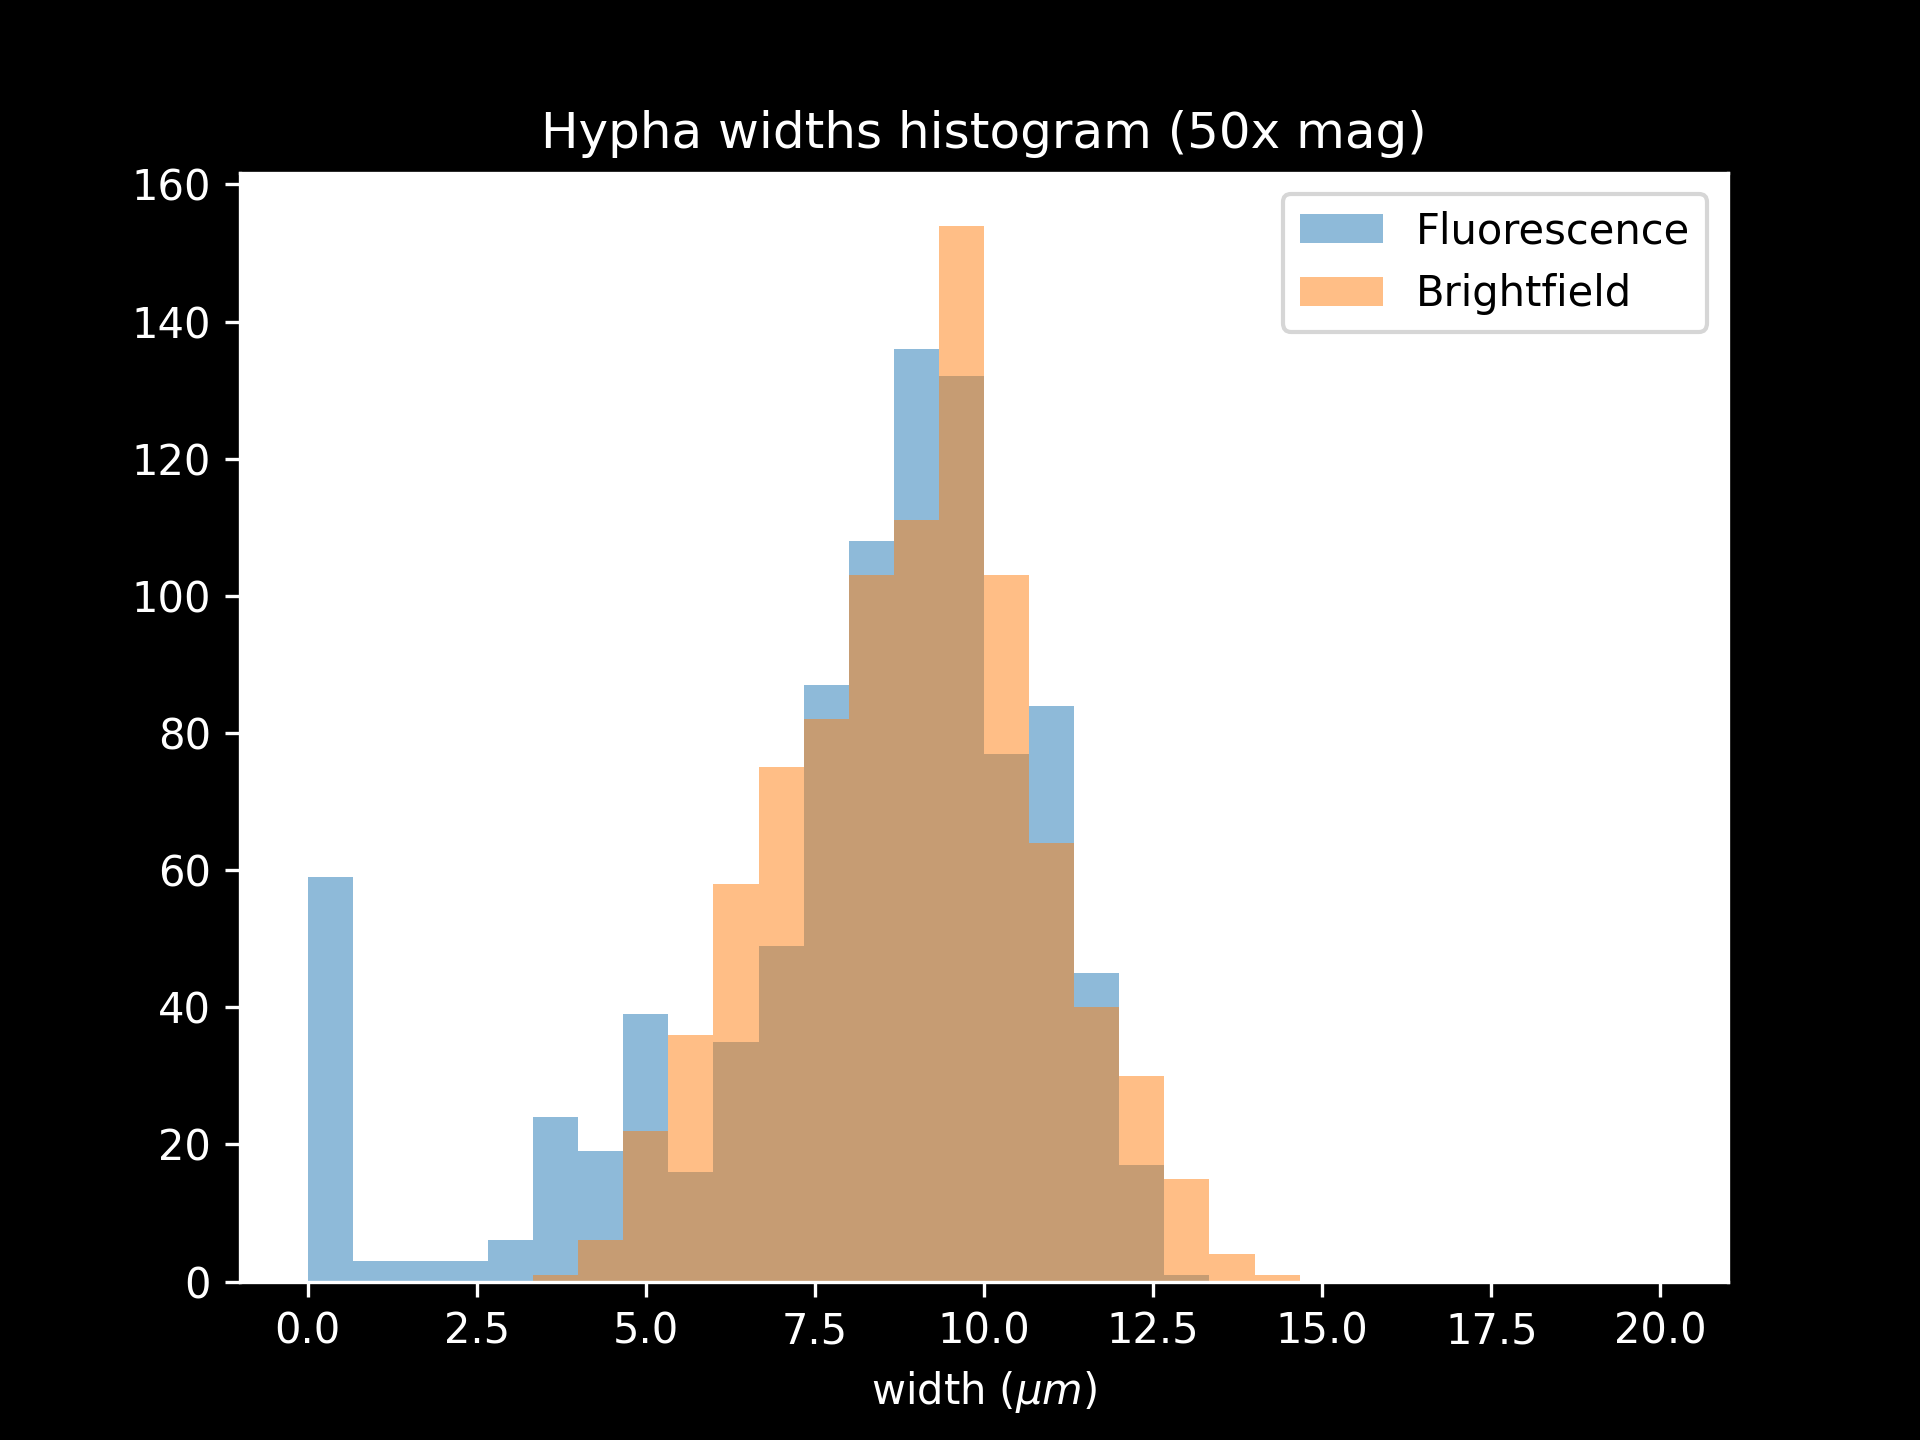

In [6]:
print(edges_data.columns)

edges_filtered = edges_data.copy()
edges_filtered = edges_filtered[edges_filtered['mag'].ge(6)]
edges_fluo = edges_filtered[edges_filtered['mode'] == "F"]
edges_bright = edges_filtered[edges_filtered['mode'] == "BF"]

fig, ax = plt.subplots(facecolor='black')
ax.hist(edges_fluo['edge_width'], bins=30, range=(0, 20), label="Fluorescence", alpha=0.5)
ax.hist(edges_bright['edge_width'], bins=30, range=(0, 20), label= "Brightfield", alpha=0.5)
ax.set_title("Hypha widths histogram (50x mag)", c='w')
ax.set_xlabel("width $(\mu m)$", c='w')
ax.legend()



### Add number of edges in each video to videos dataframe

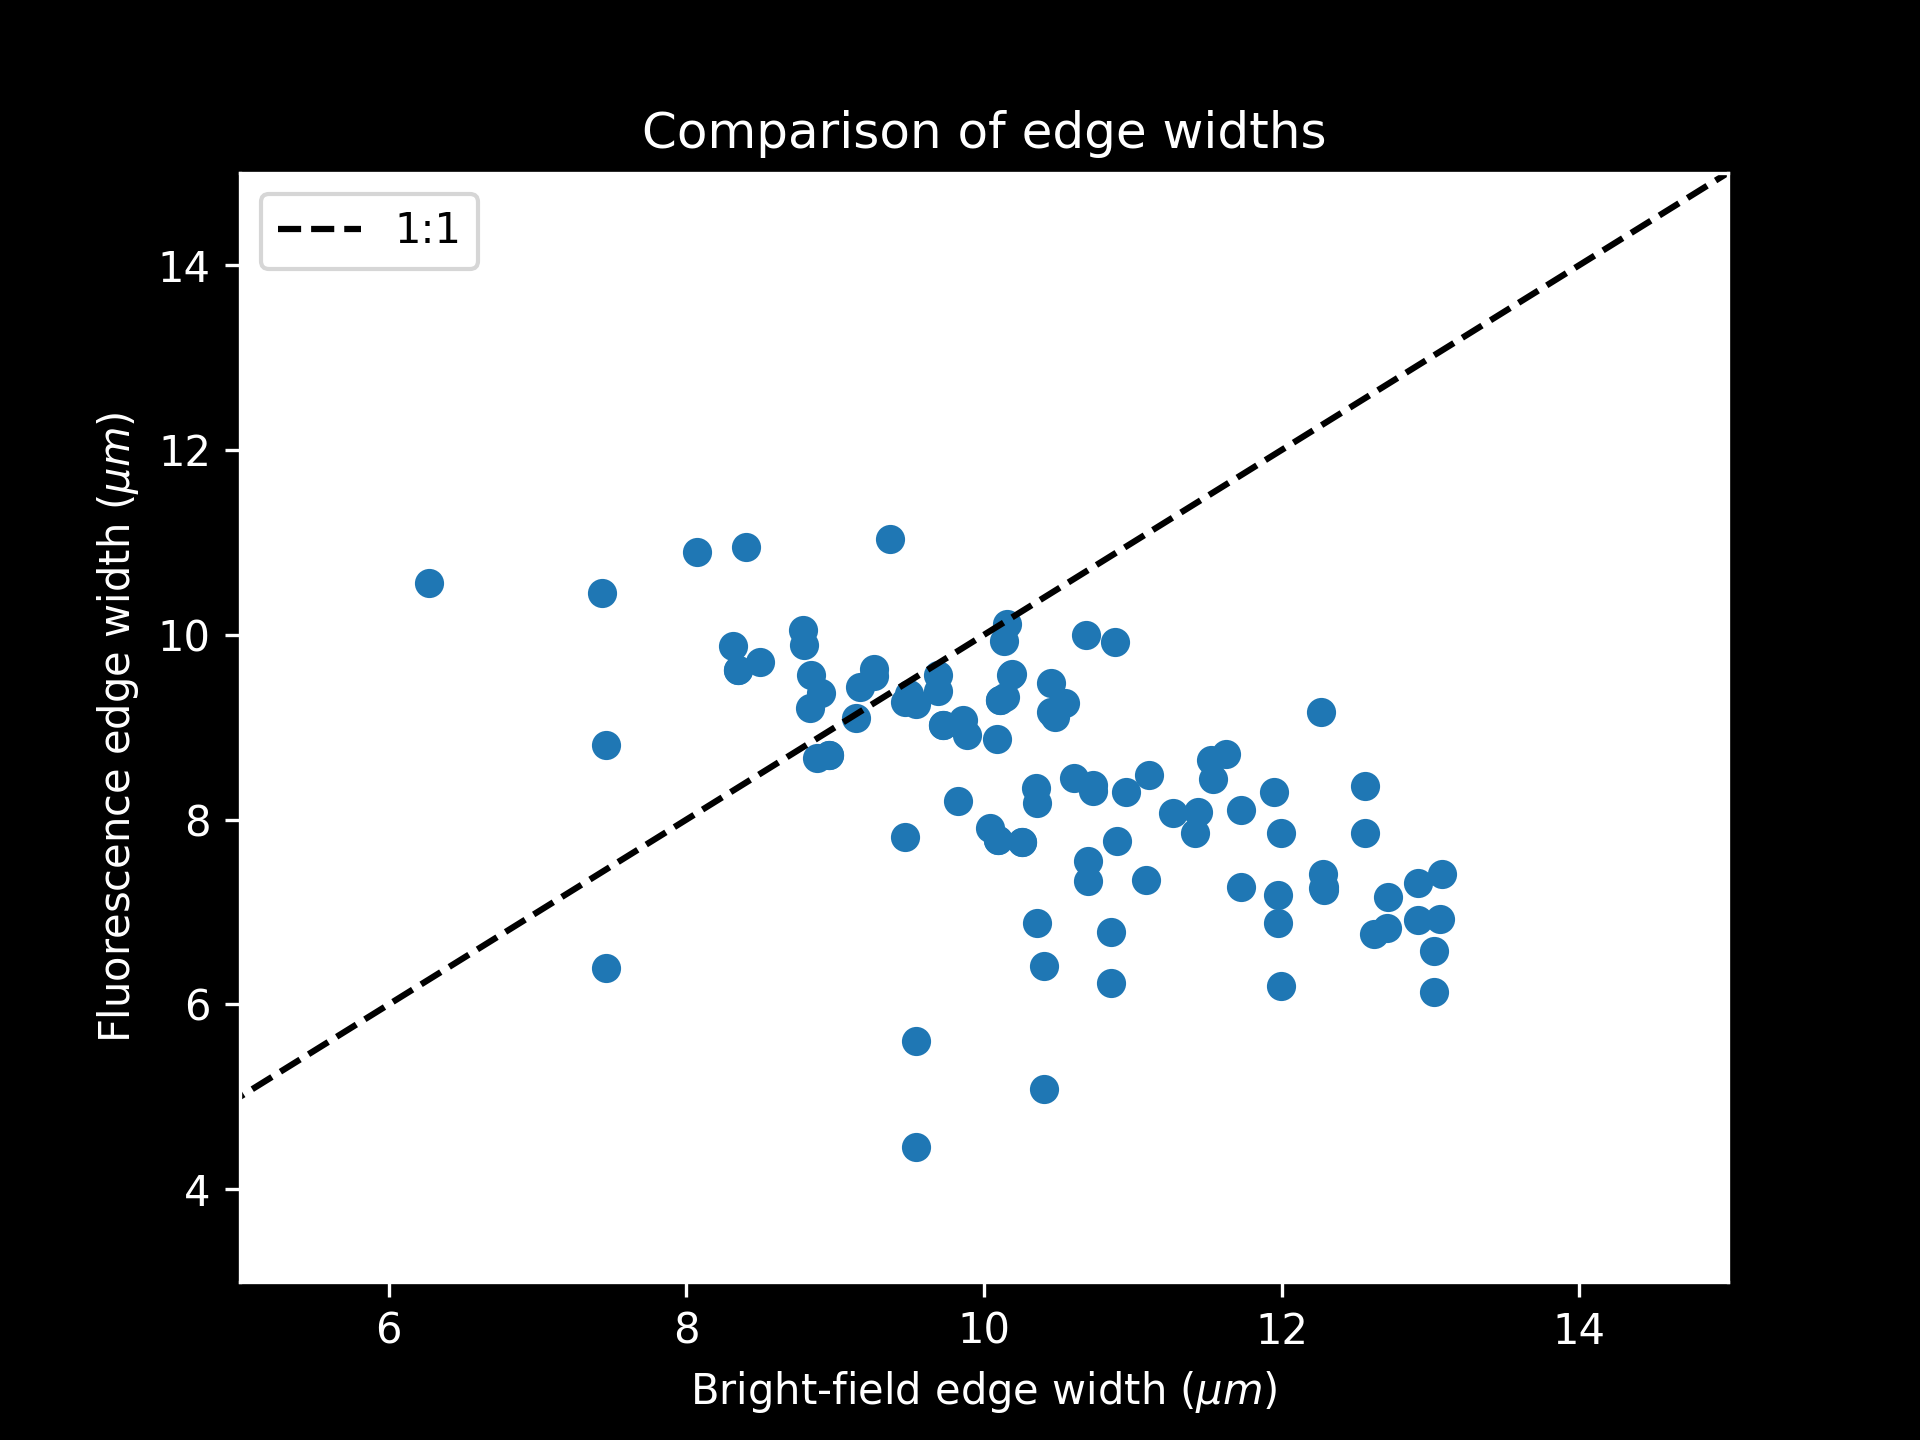

In [7]:
width_pairs = []

videos_singlets = videos_data[videos_data['nr_of_edges'] == 1]
for nr in videos_singlets['Plate_nr'].unique():
    vid_single_plate = videos_singlets[videos_singlets['Plate_nr'] == nr]
    for coord in vid_single_plate['coords'].unique():
        single_edge = vid_single_plate[vid_single_plate['coords'] == coord]
        if len(single_edge) > 1:
            if single_edge['mode'].nunique() == 2:
                single_edge_bf = single_edge[single_edge['mode'] == 'BF']
                single_edge_fl = single_edge[single_edge['mode'] == 'F']
                for title_bf in single_edge_bf['video_title']:
                    edge_bf_data = edges_data[edges_data['video_title'] == title_bf]
                    edge_bf_width = edge_bf_data['edge_width'].iloc[0]
                    for title_f in single_edge_fl['video_title']:
                        edge_fl_data = edges_data[edges_data['video_title'] == title_f]
                        edge_fl_width = edge_fl_data['edge_width'].iloc[0]
                        if edge_fl_data['binning'].iloc[0] == 1:
                            edge_fl_width *= 2
                        width_pairs.append([edge_bf_width, edge_fl_width])

width_pairs = np.array(width_pairs)

fig, ax = plt.subplots(facecolor='black')
for pair in width_pairs:
    ax.scatter(pair[0], pair[1], c='tab:blue')
ax.set_ylim([3, 15])
ax.set_xlim([5, 15])
ax.set_xlabel("Bright-field edge width $(\mu m)$", c='w')
ax.set_ylabel("Fluorescence edge width $(\mu m)$", c='w')
ax.plot(np.arange(0, 20, 1), np.arange(0, 20, 1), c='black', linestyle='--', label='1:1')
ax.set_title("Comparison of edge widths", c='w')
ax.legend()


[452 462 510 537 530 545 532 527 528 552 558]
2005


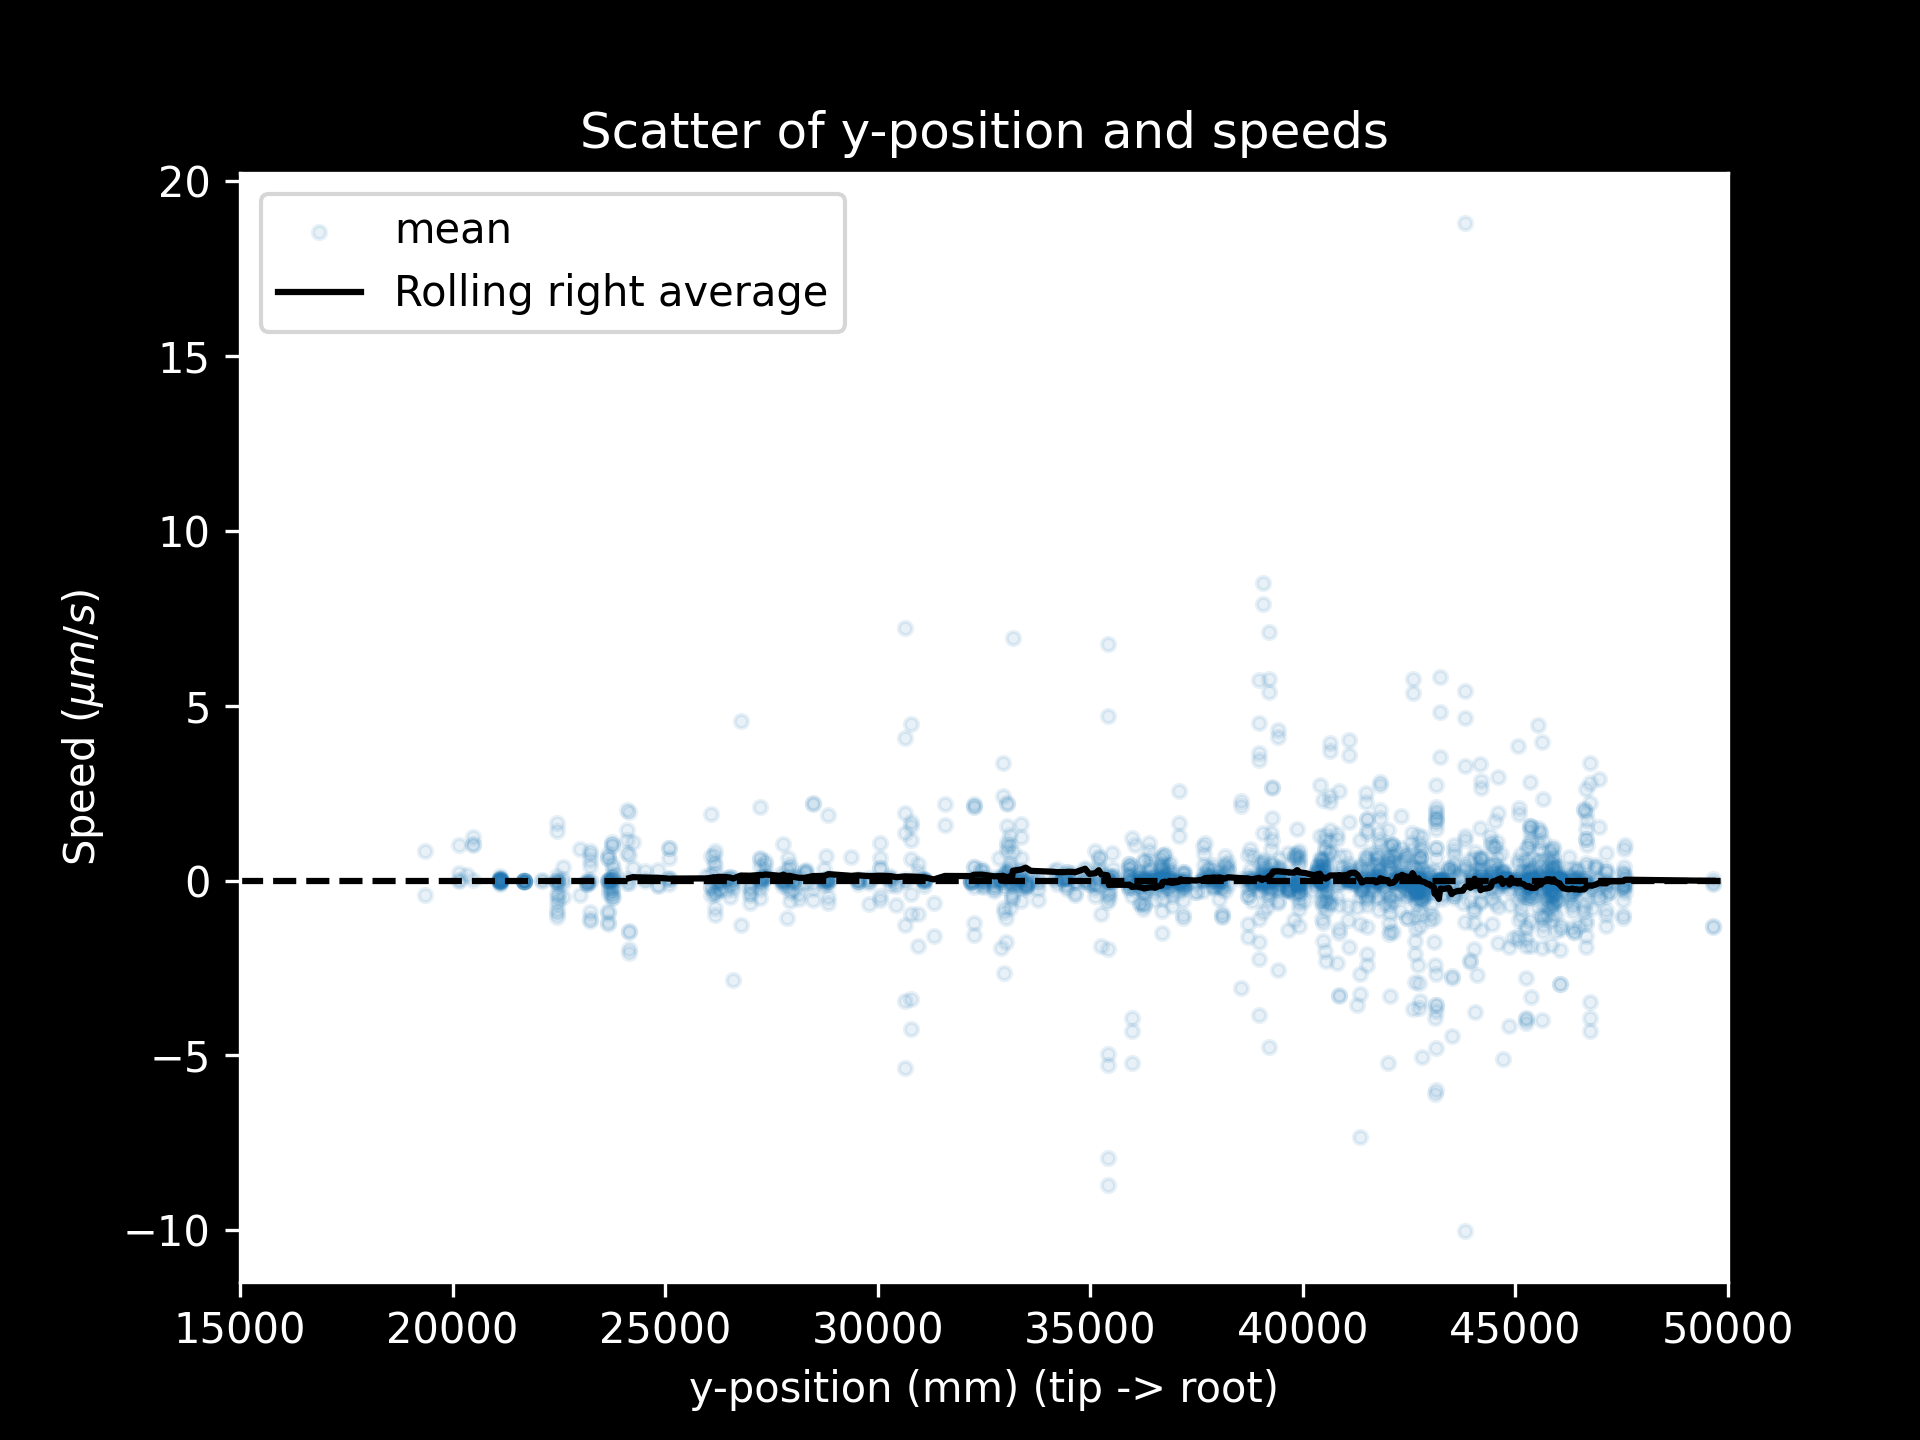

In [66]:
cov_thresh = 0.3

edges_filtered = edges_data[edges_data['coverage_tot'].ge(cov_thresh)]

fig, ax = plt.subplots(facecolor='black')
edges_fluo = edges_filtered
print(edges_filtered["Plate_nr"].unique())
plate_nr = 558
edges_filtered_nr = edges_fluo
print(len(edges_fluo))

ax.scatter(edges_filtered_nr['ypos'], edges_filtered_nr['speed_mean'], s=10, alpha=0.1, label='mean')
# ax.scatter(edges_filtered_nr['ypos'], edges_filtered_nr['speed_left'], s=10, alpha=0.1, label='to root')
ax.axhline(c='black', linestyle='--')

# ax.scatter(edges_filtered_nr['edge_width'], edges_filtered_nr['speed_mean'], s=10, alpha=0.2, label='mean')
y_series = sorted(edges_filtered_nr['ypos'].unique())
y_r_mean = np.array([edges_filtered_nr['speed_mean'][edges_filtered['ypos'] == y].mean() for y in y_series])
# y_r_std = np.array([edges_filtered_nr['speed_right'][edges_filtered['ypos'] == y].std() for y in y_series])
# y_l_mean = np.array([edges_filtered_nr['speed_left'][edges_filtered['ypos'] == y].mean() for y in y_series])
# y_l_std = np.array([edges_filtered_nr['speed_left'][edges_filtered['ypos'] == y].std() for y in y_series])

y_r = pd.Series(data=y_r_mean, index = y_series)
# y_l = pd.Series(data=y_l_mean, index = y_series)

ax.plot(y_r.rolling(20).mean(), c='black', label='Rolling right average')
# ax.fill_between(y_series, 
#                       y_r_mean + y_r_std, 
#                       y_r_mean - y_r_std, 
#                       alpha=0.5, facecolor='tab:blue')
# ax.plot(y_l.rolling(20).mean(), c='tab:orange', label='Rolling left average')
# ax.fill_between(y_series, 
#                       y_l_mean + y_l_std, 
#                       y_l_mean - y_l_std, 
#                       alpha=0.5, facecolor='tab:orange')

# ax.set_xlim((0, 20))
ax.set_ylabel("Speed $(\mu m /s )$", c='w')
ax.set_xlabel("y-position (mm) (tip -> root)", c='w')
ax.set_title(f"Scatter of y-position and speeds", c='w')
ax.set_xlim((15000, 50000))
ax.legend()

### Positional distribution

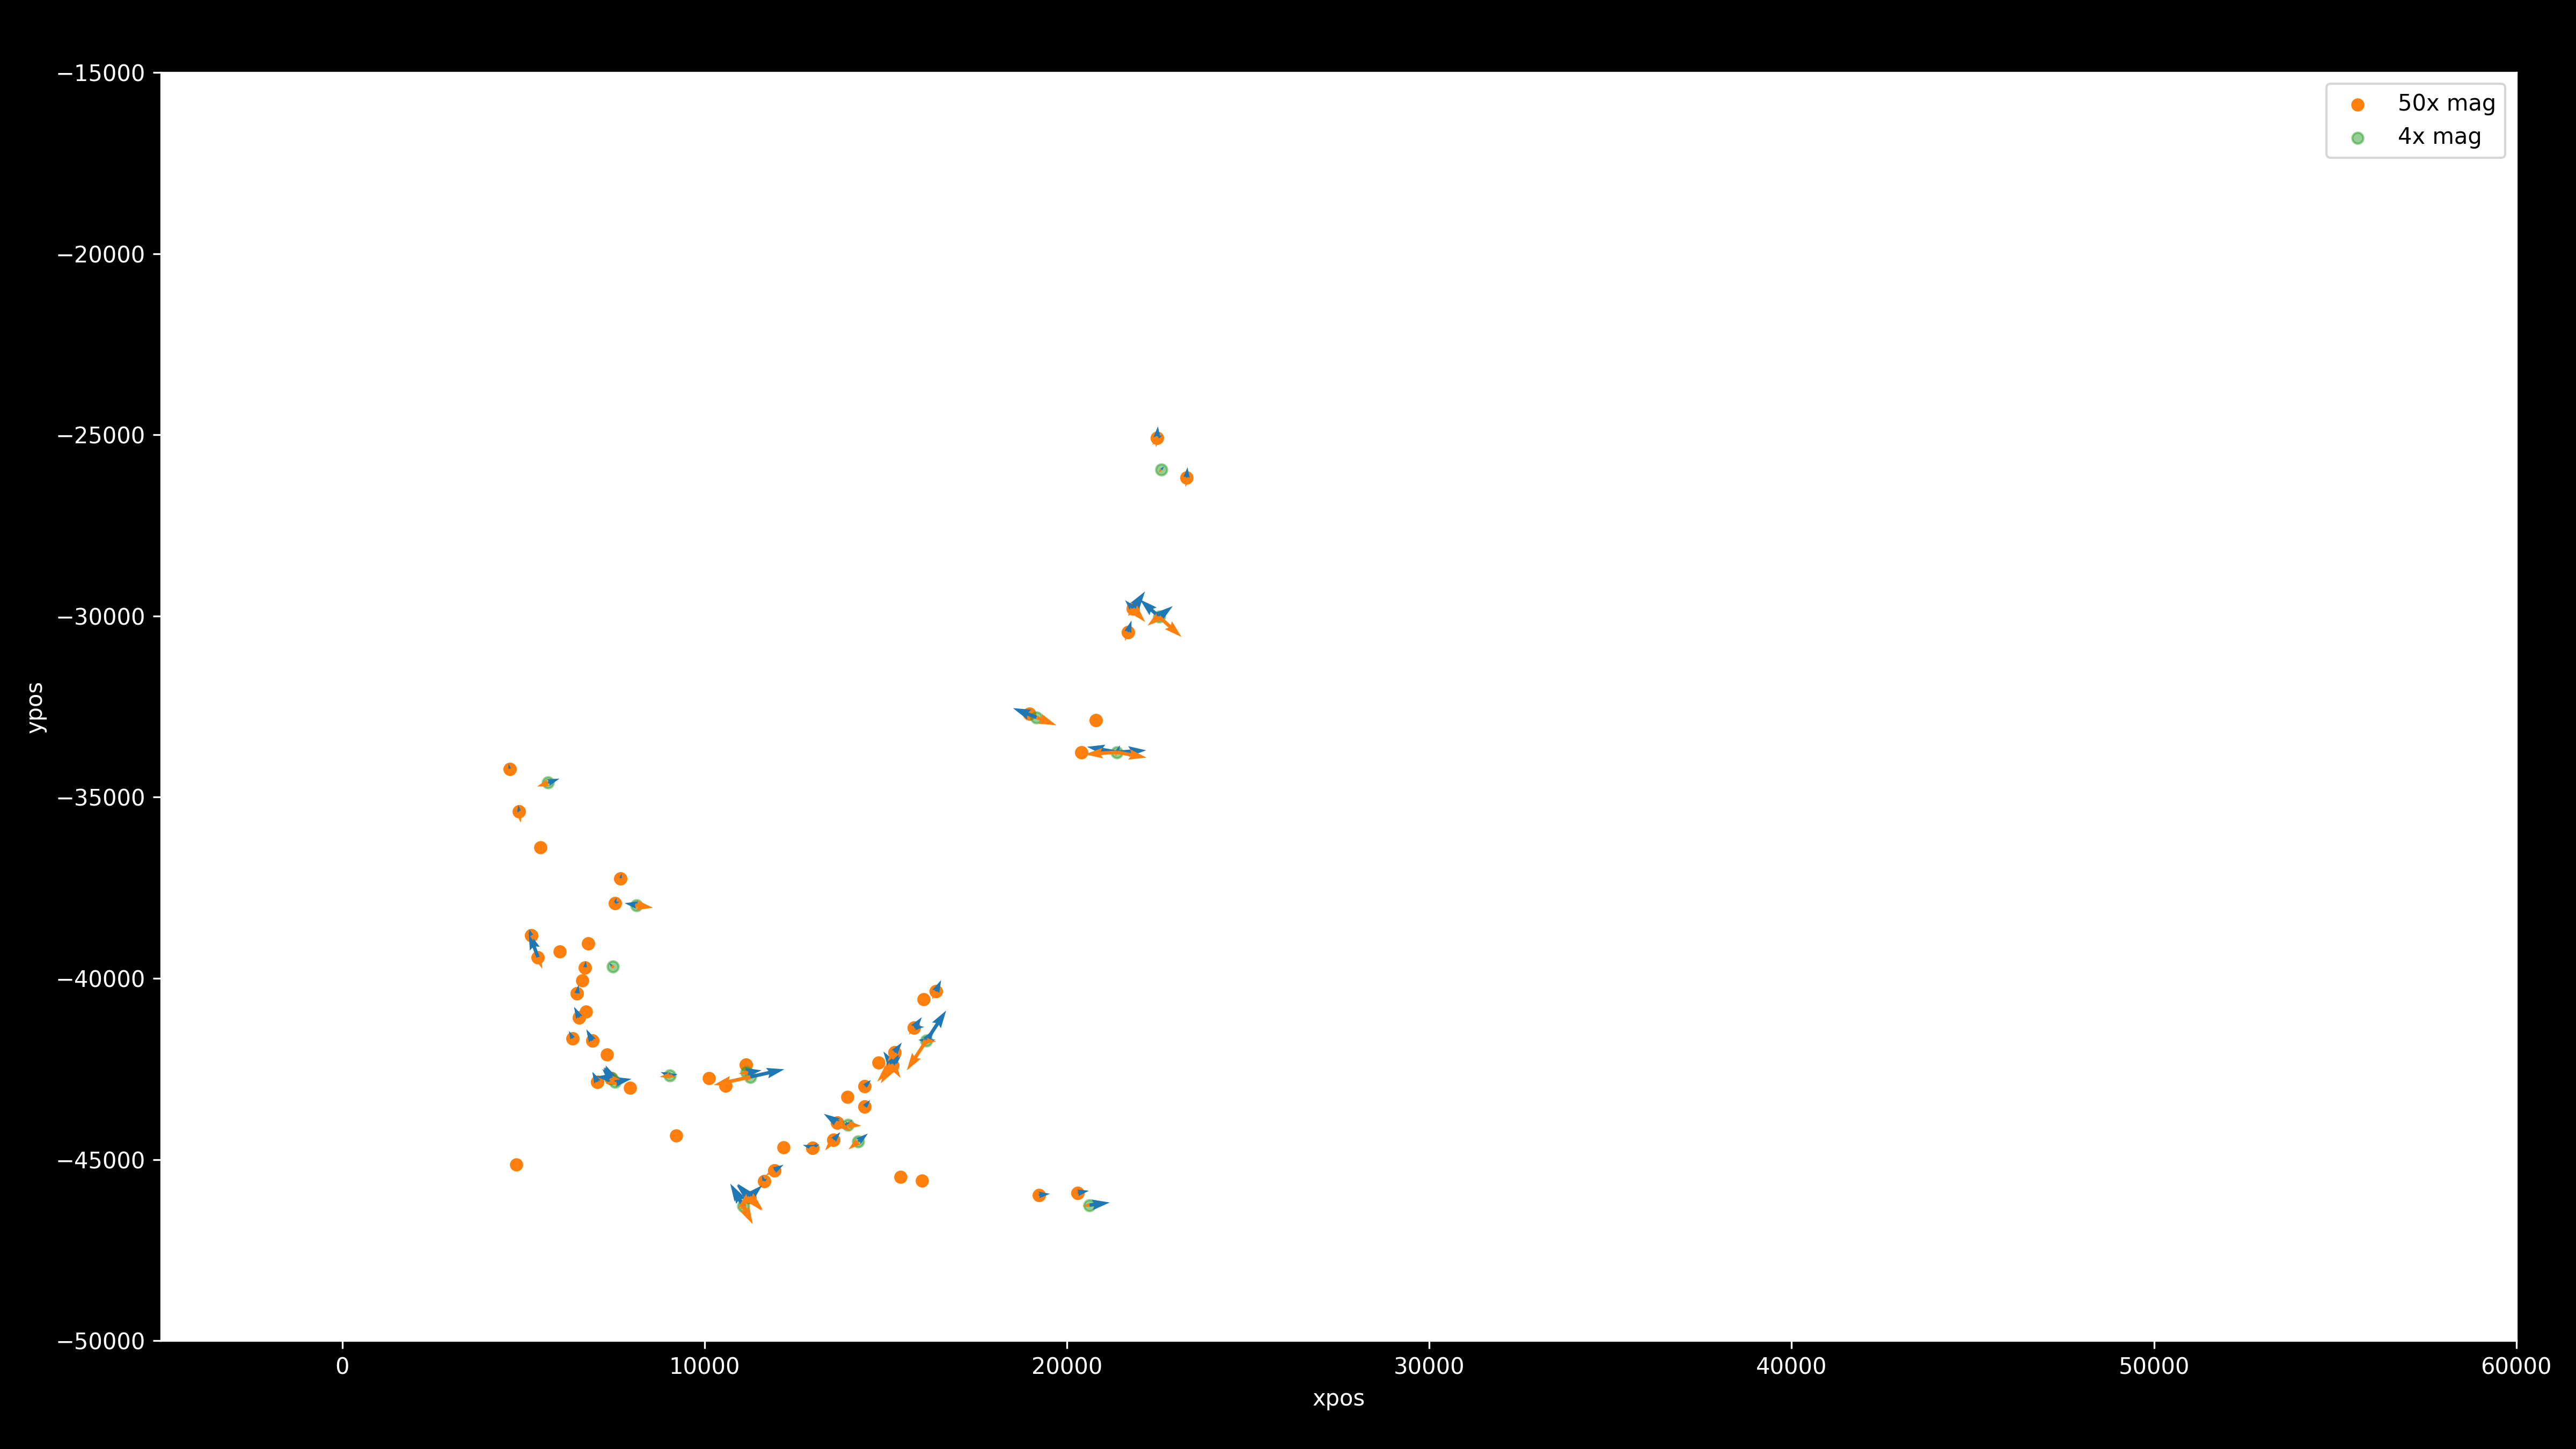

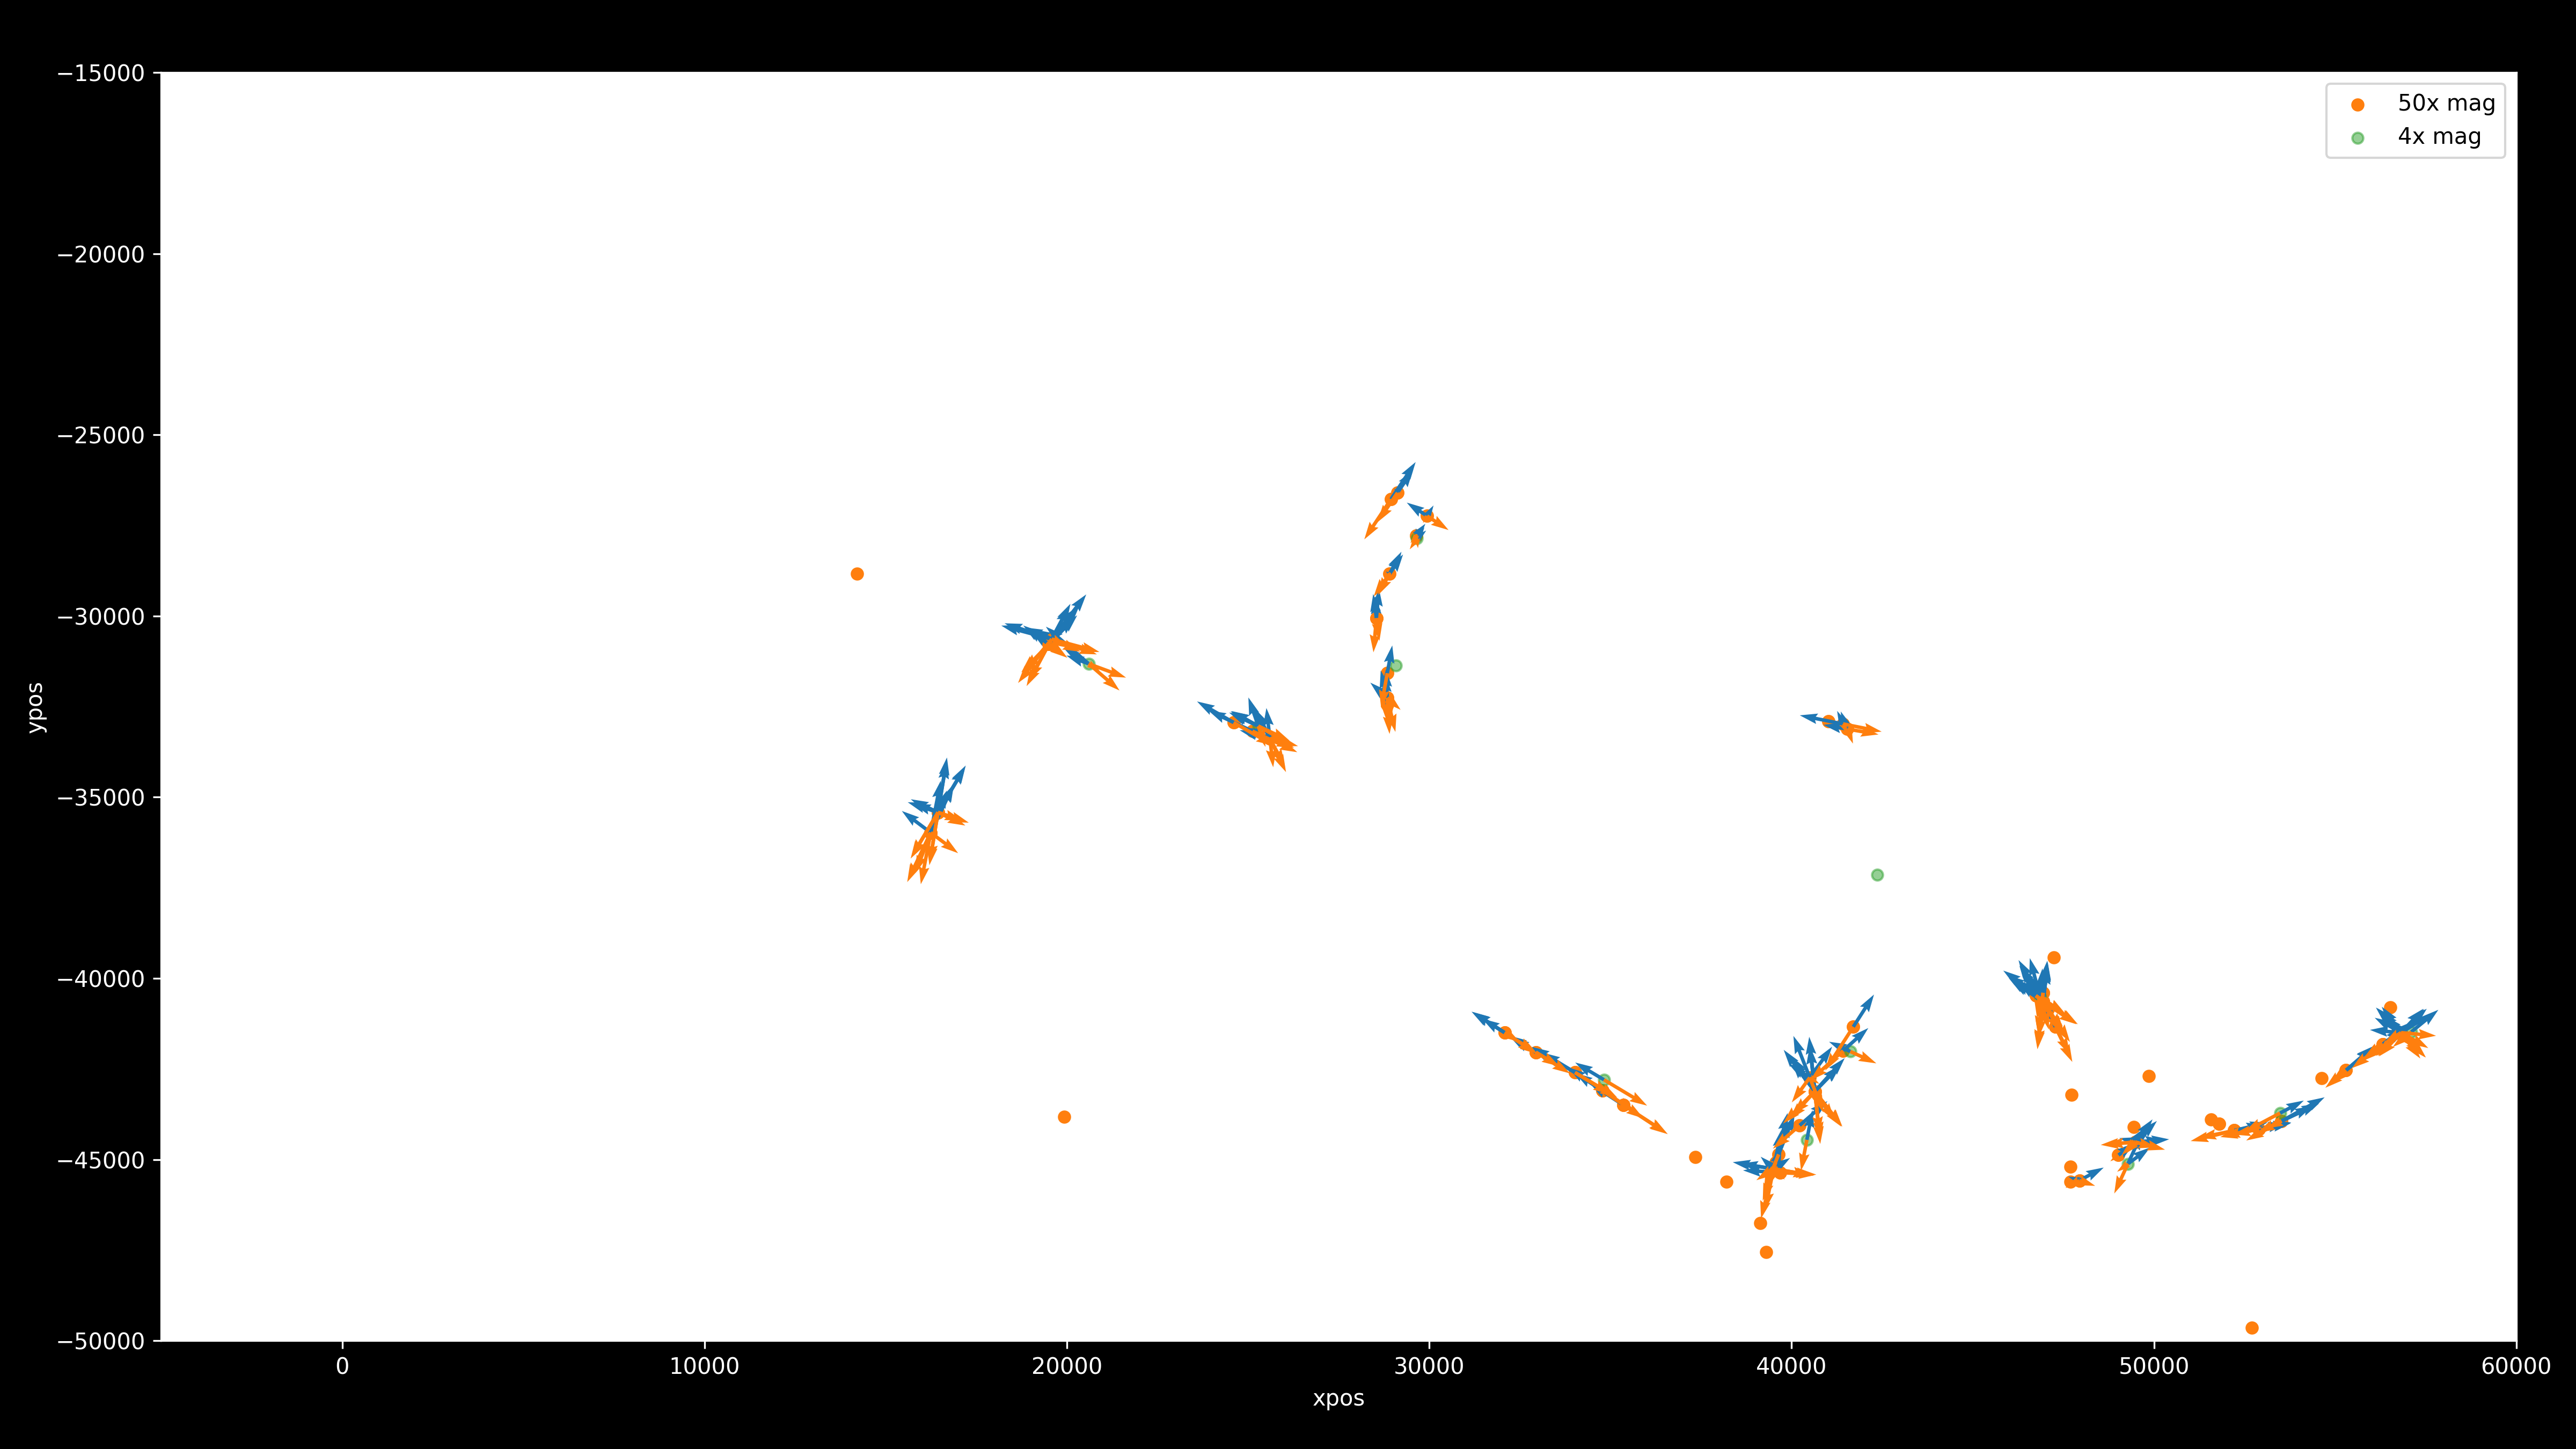

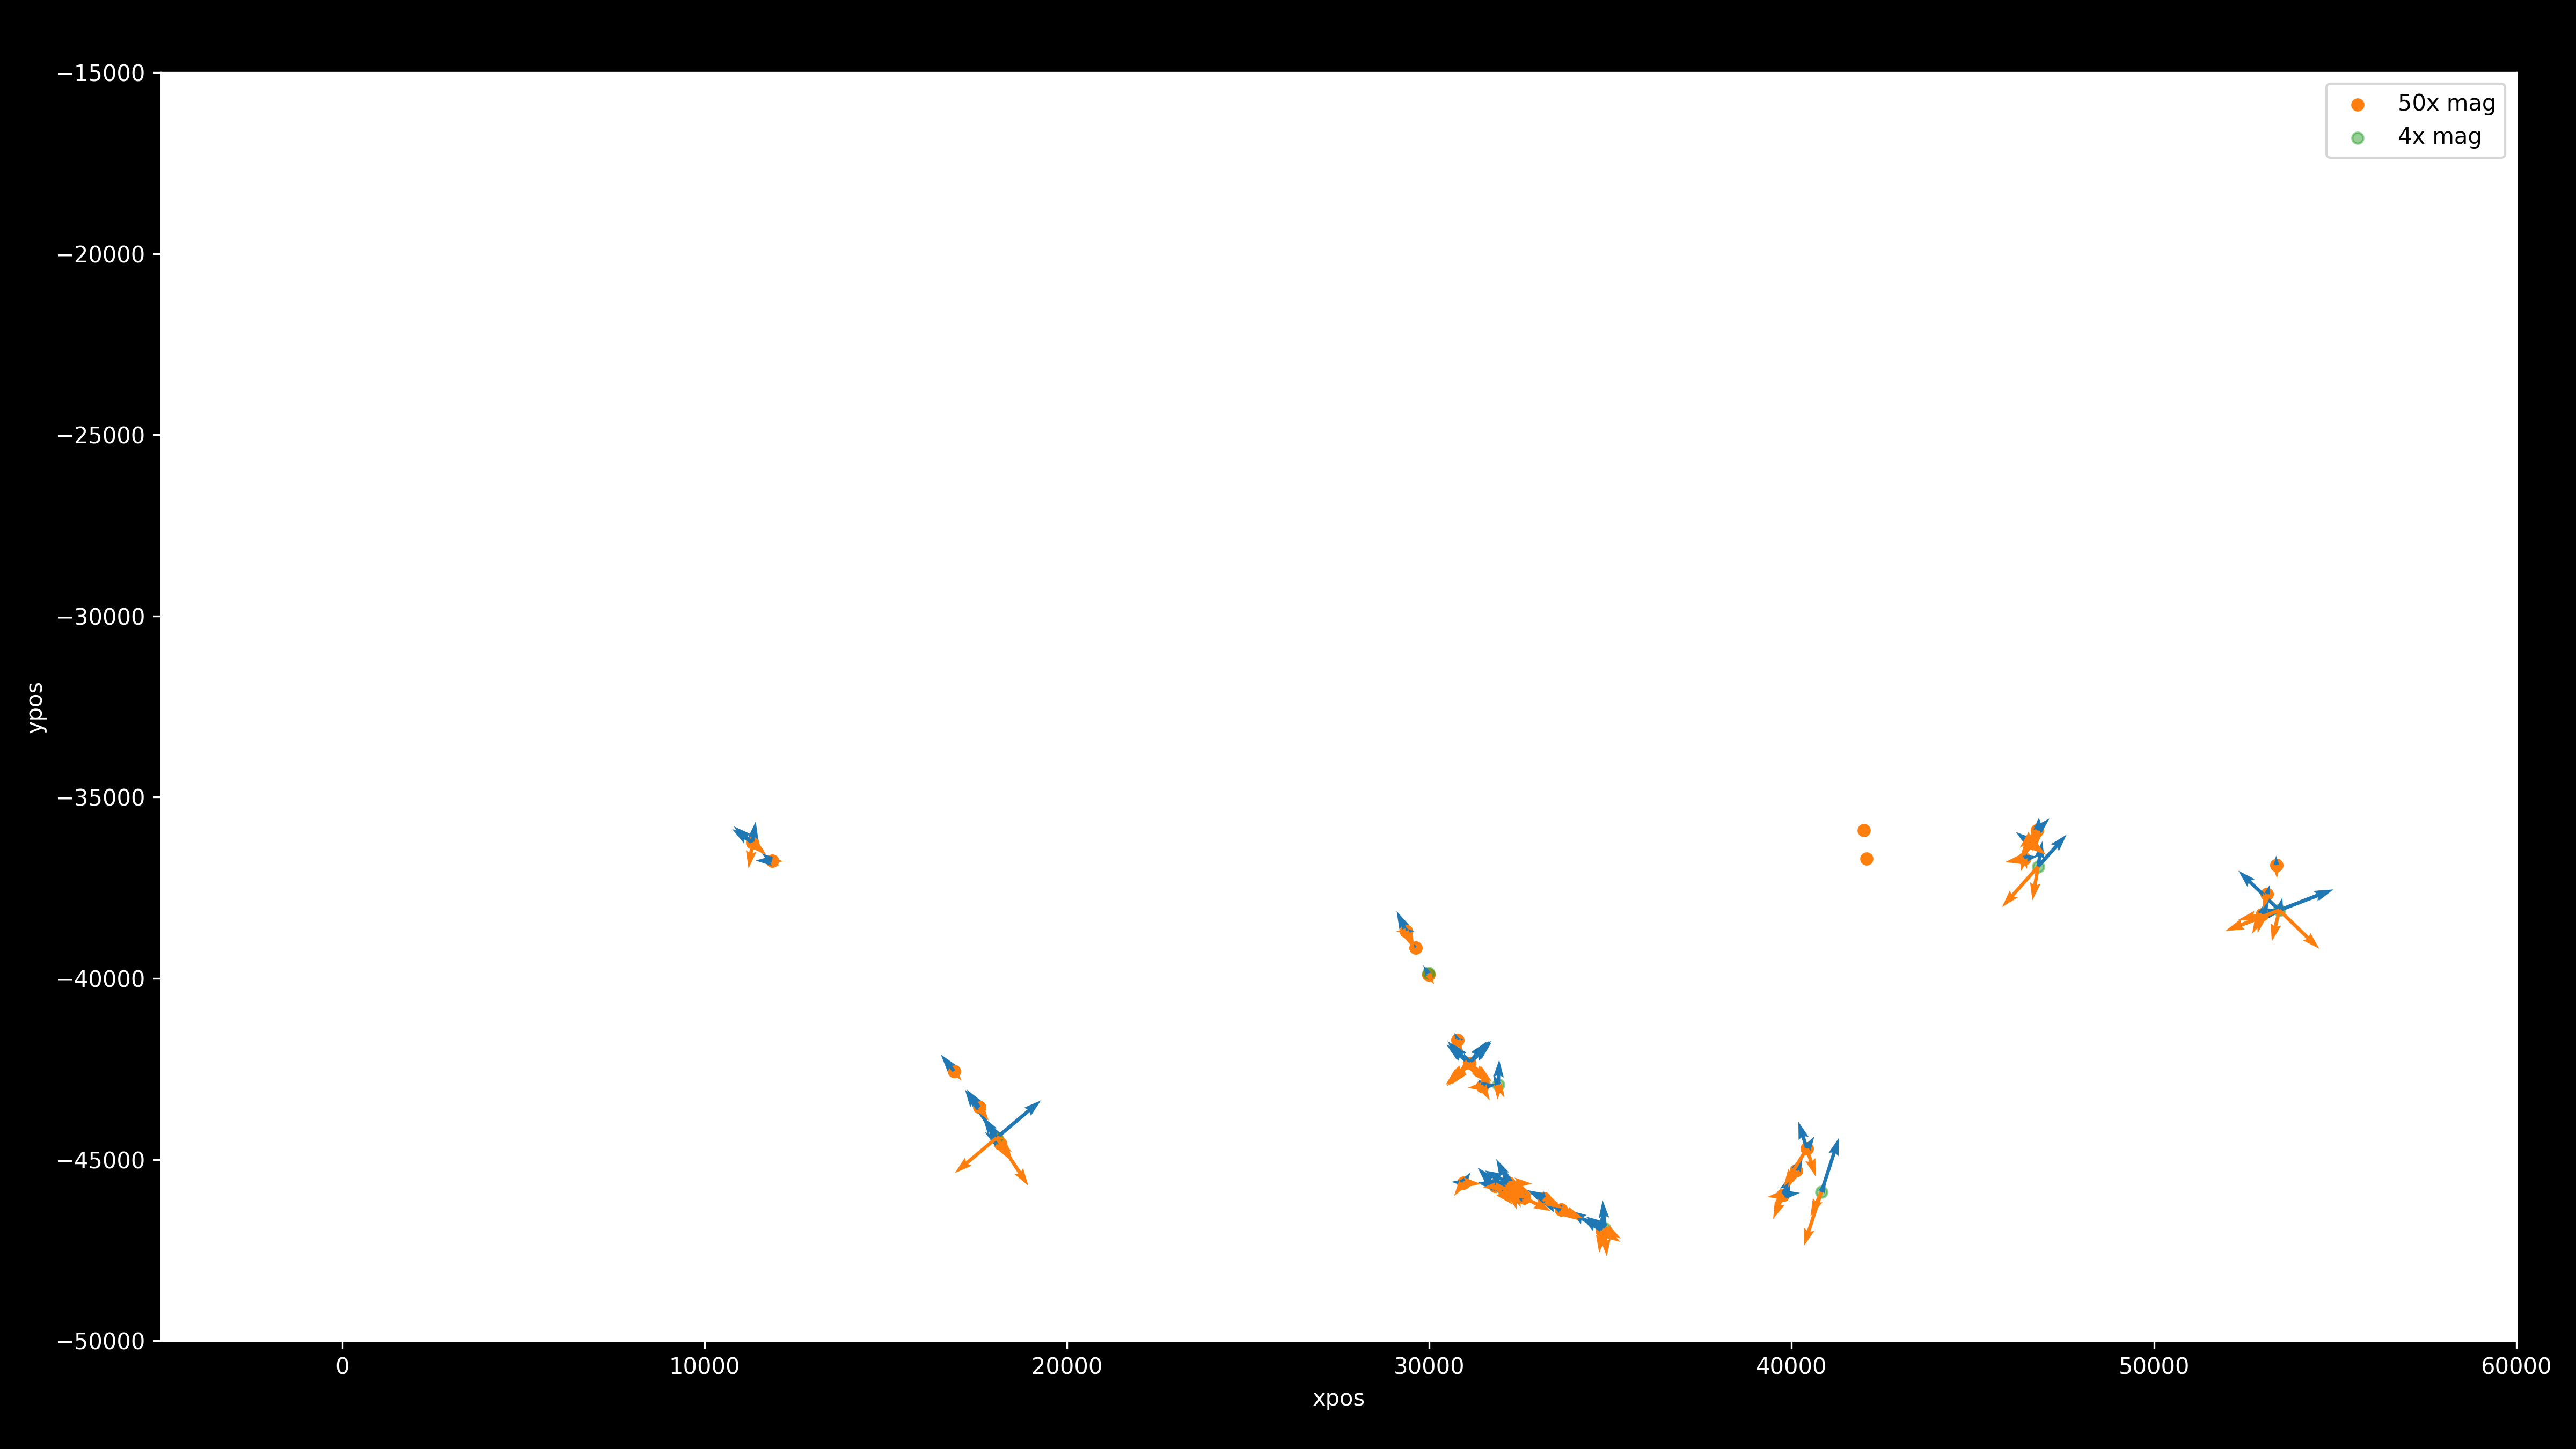

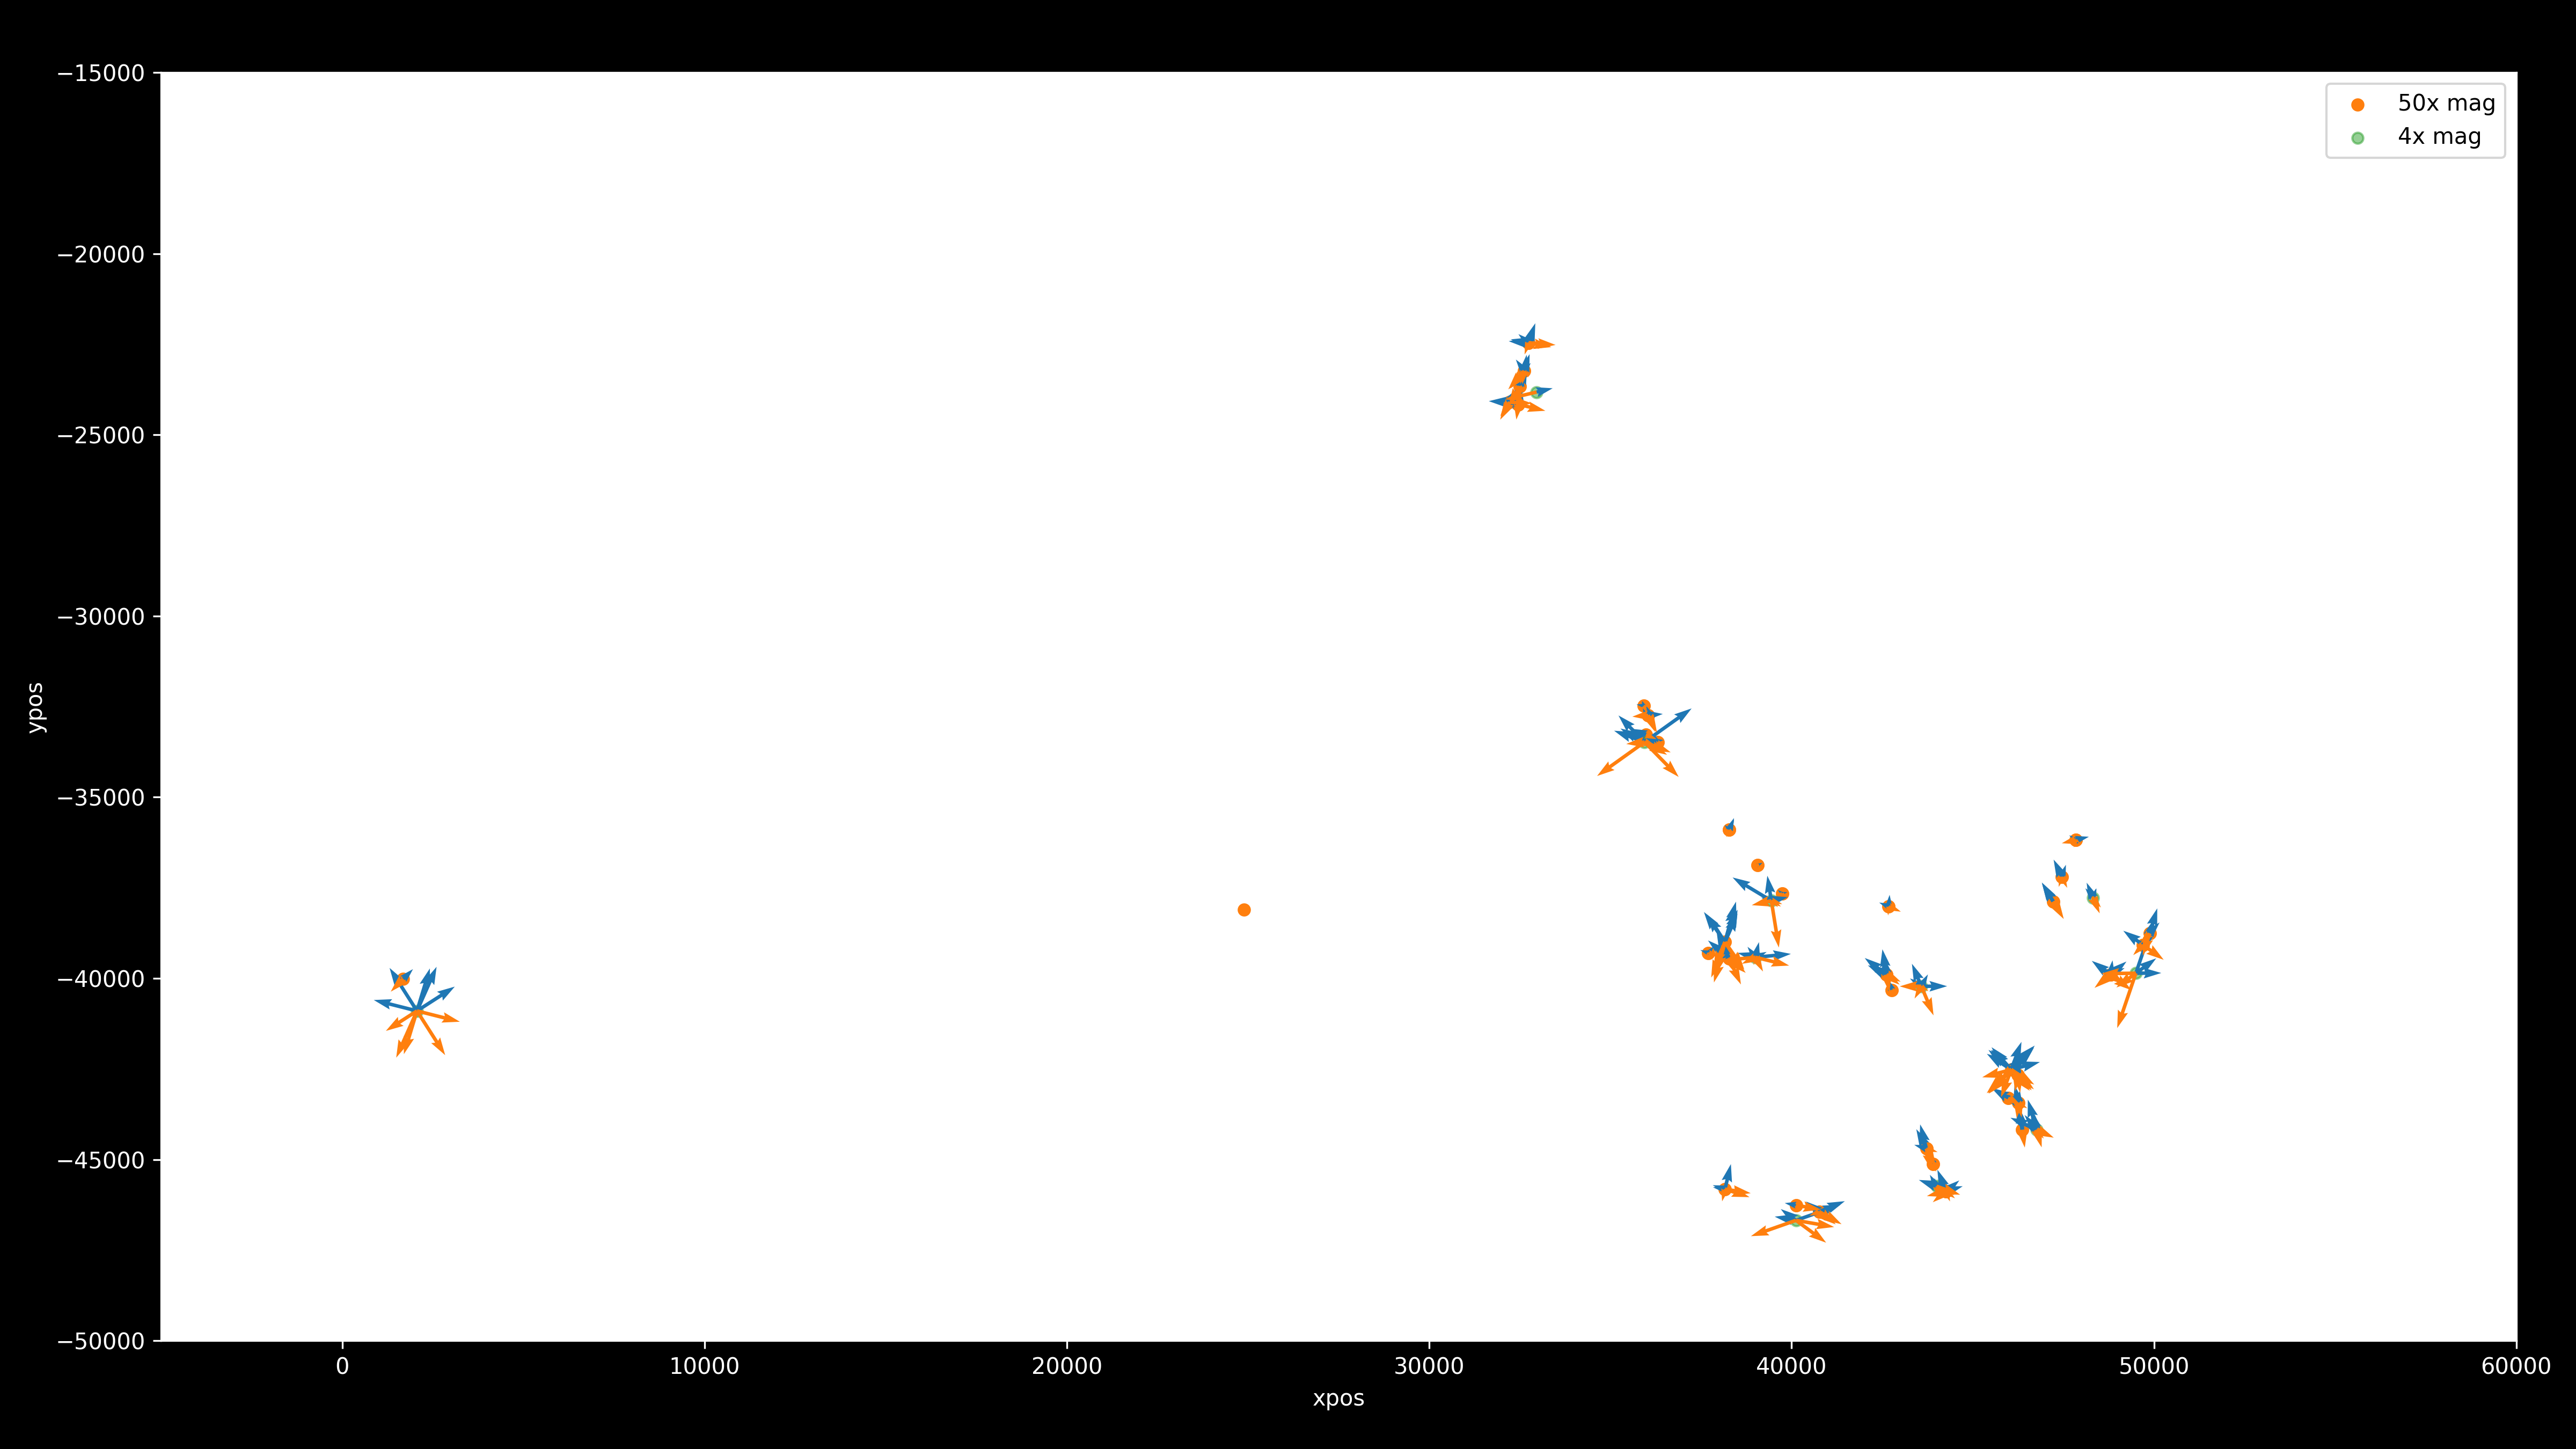

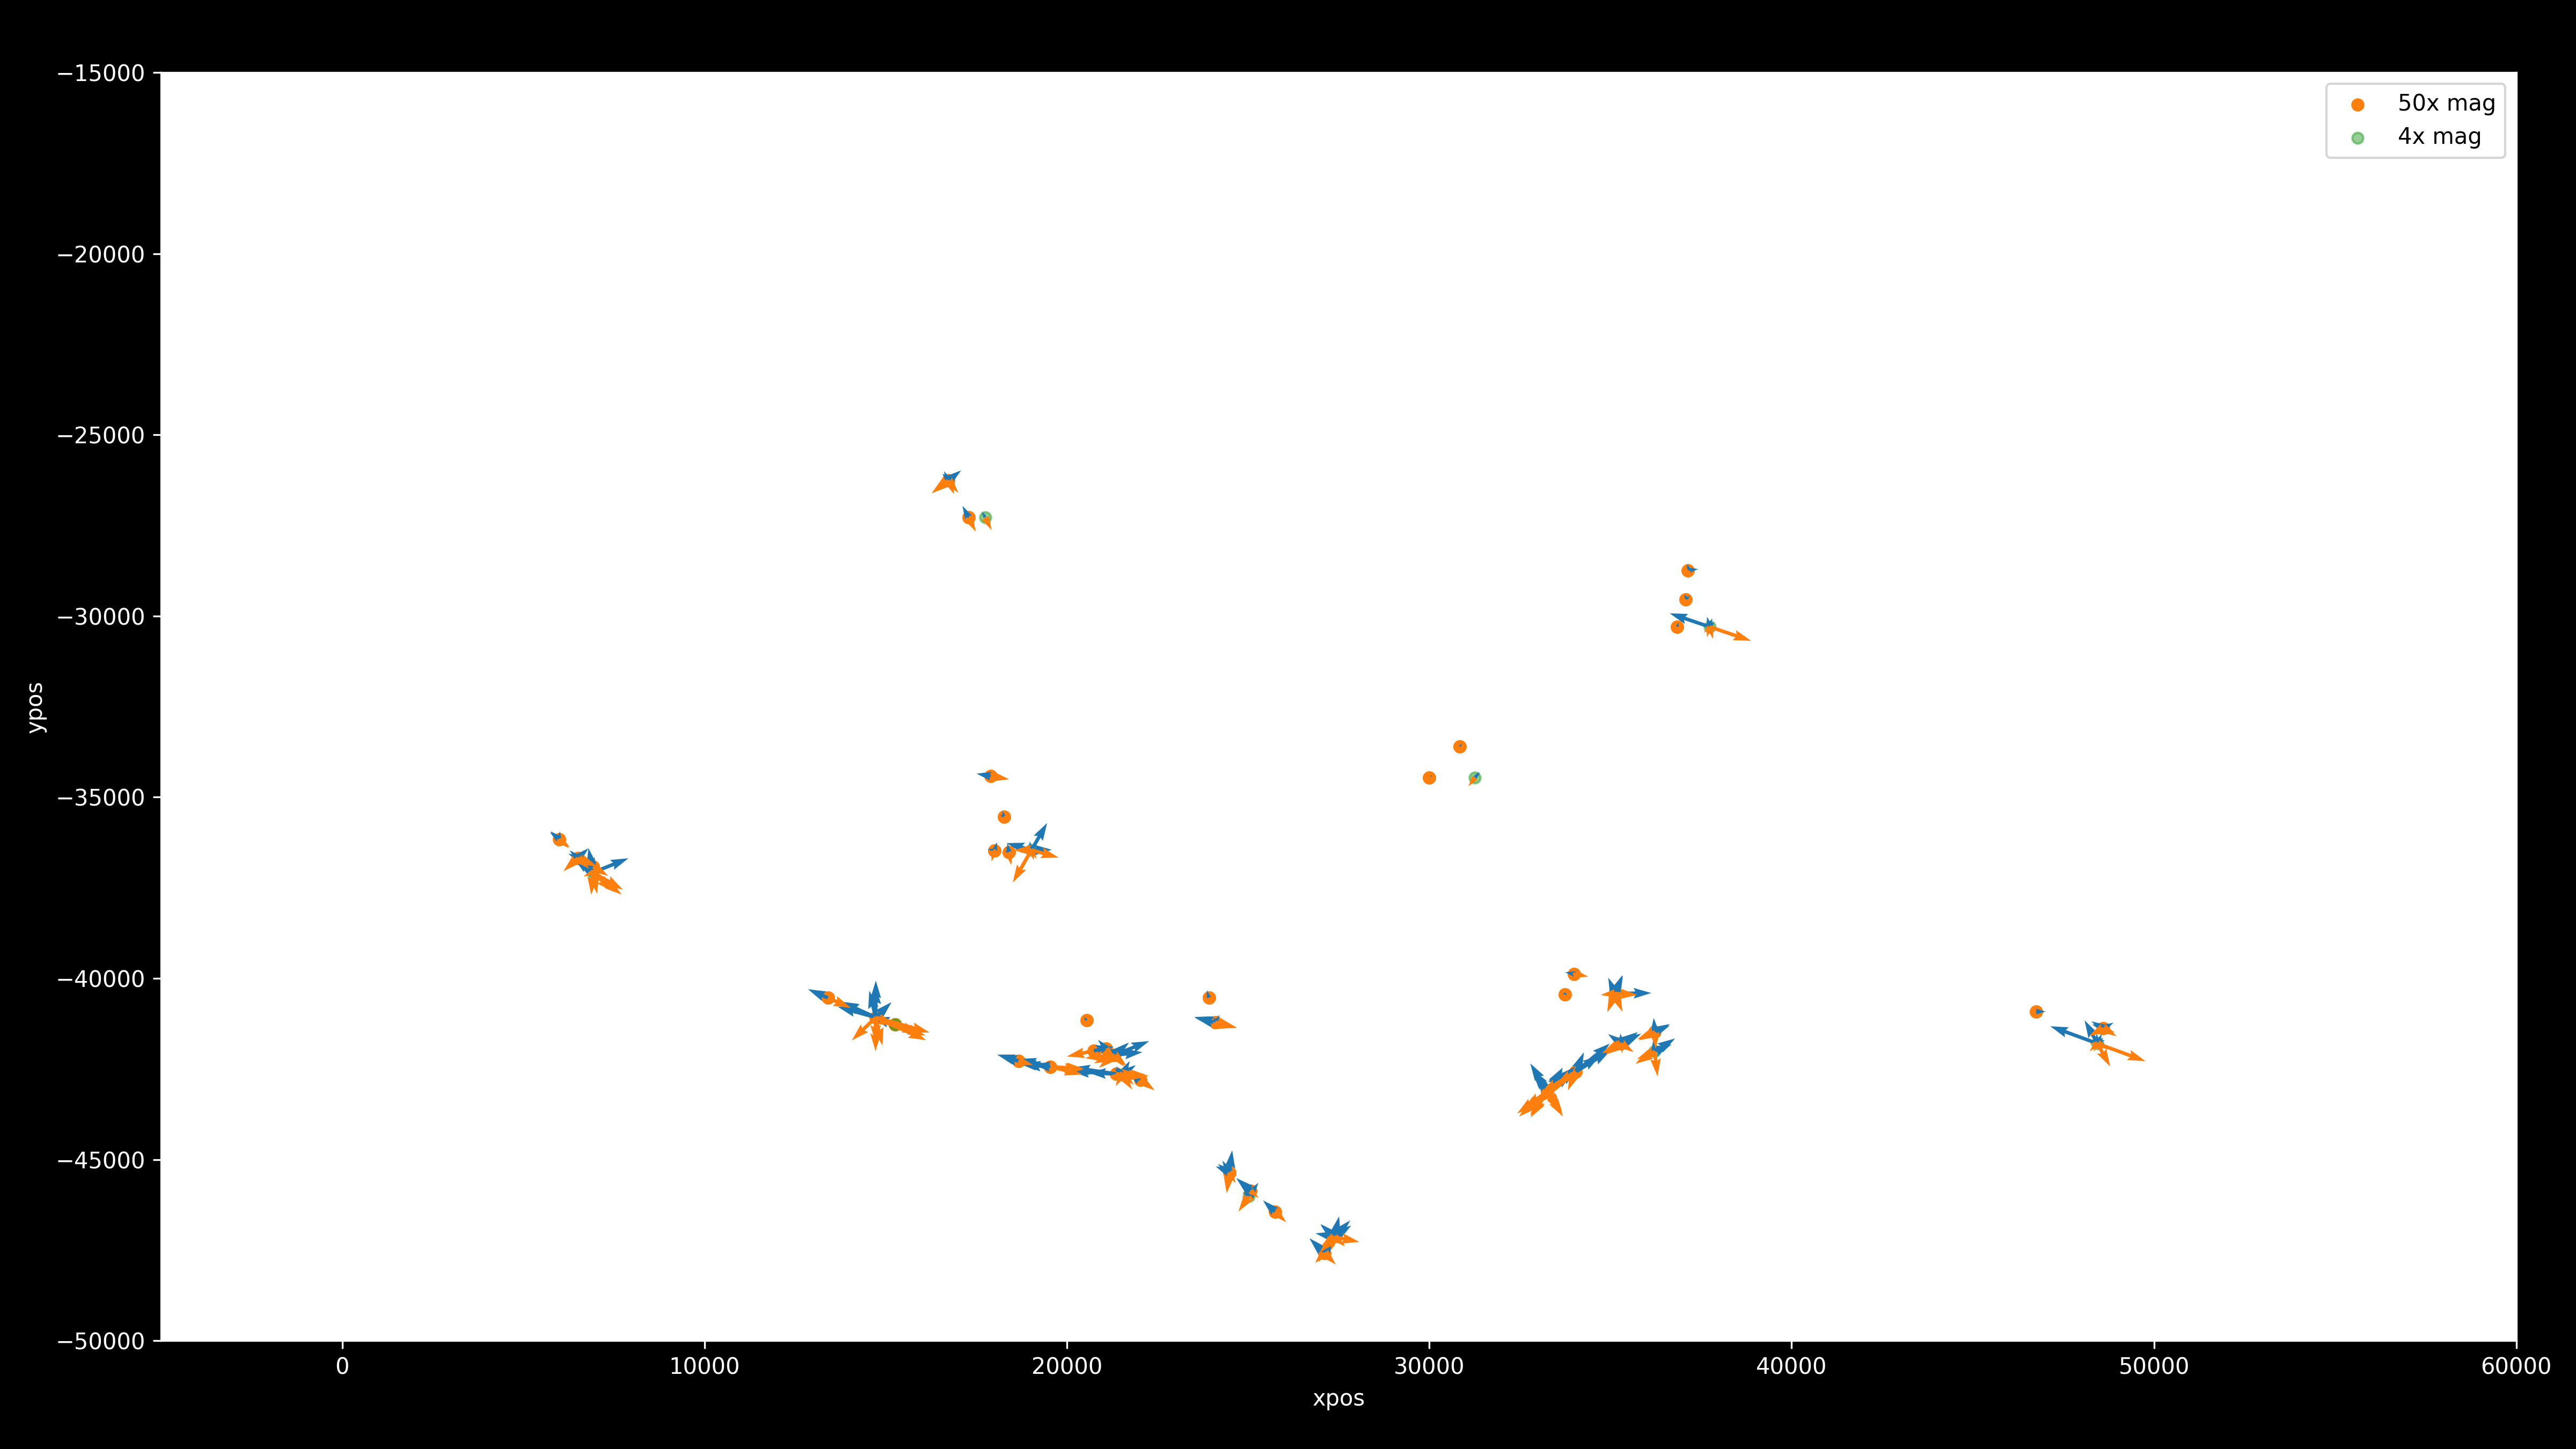

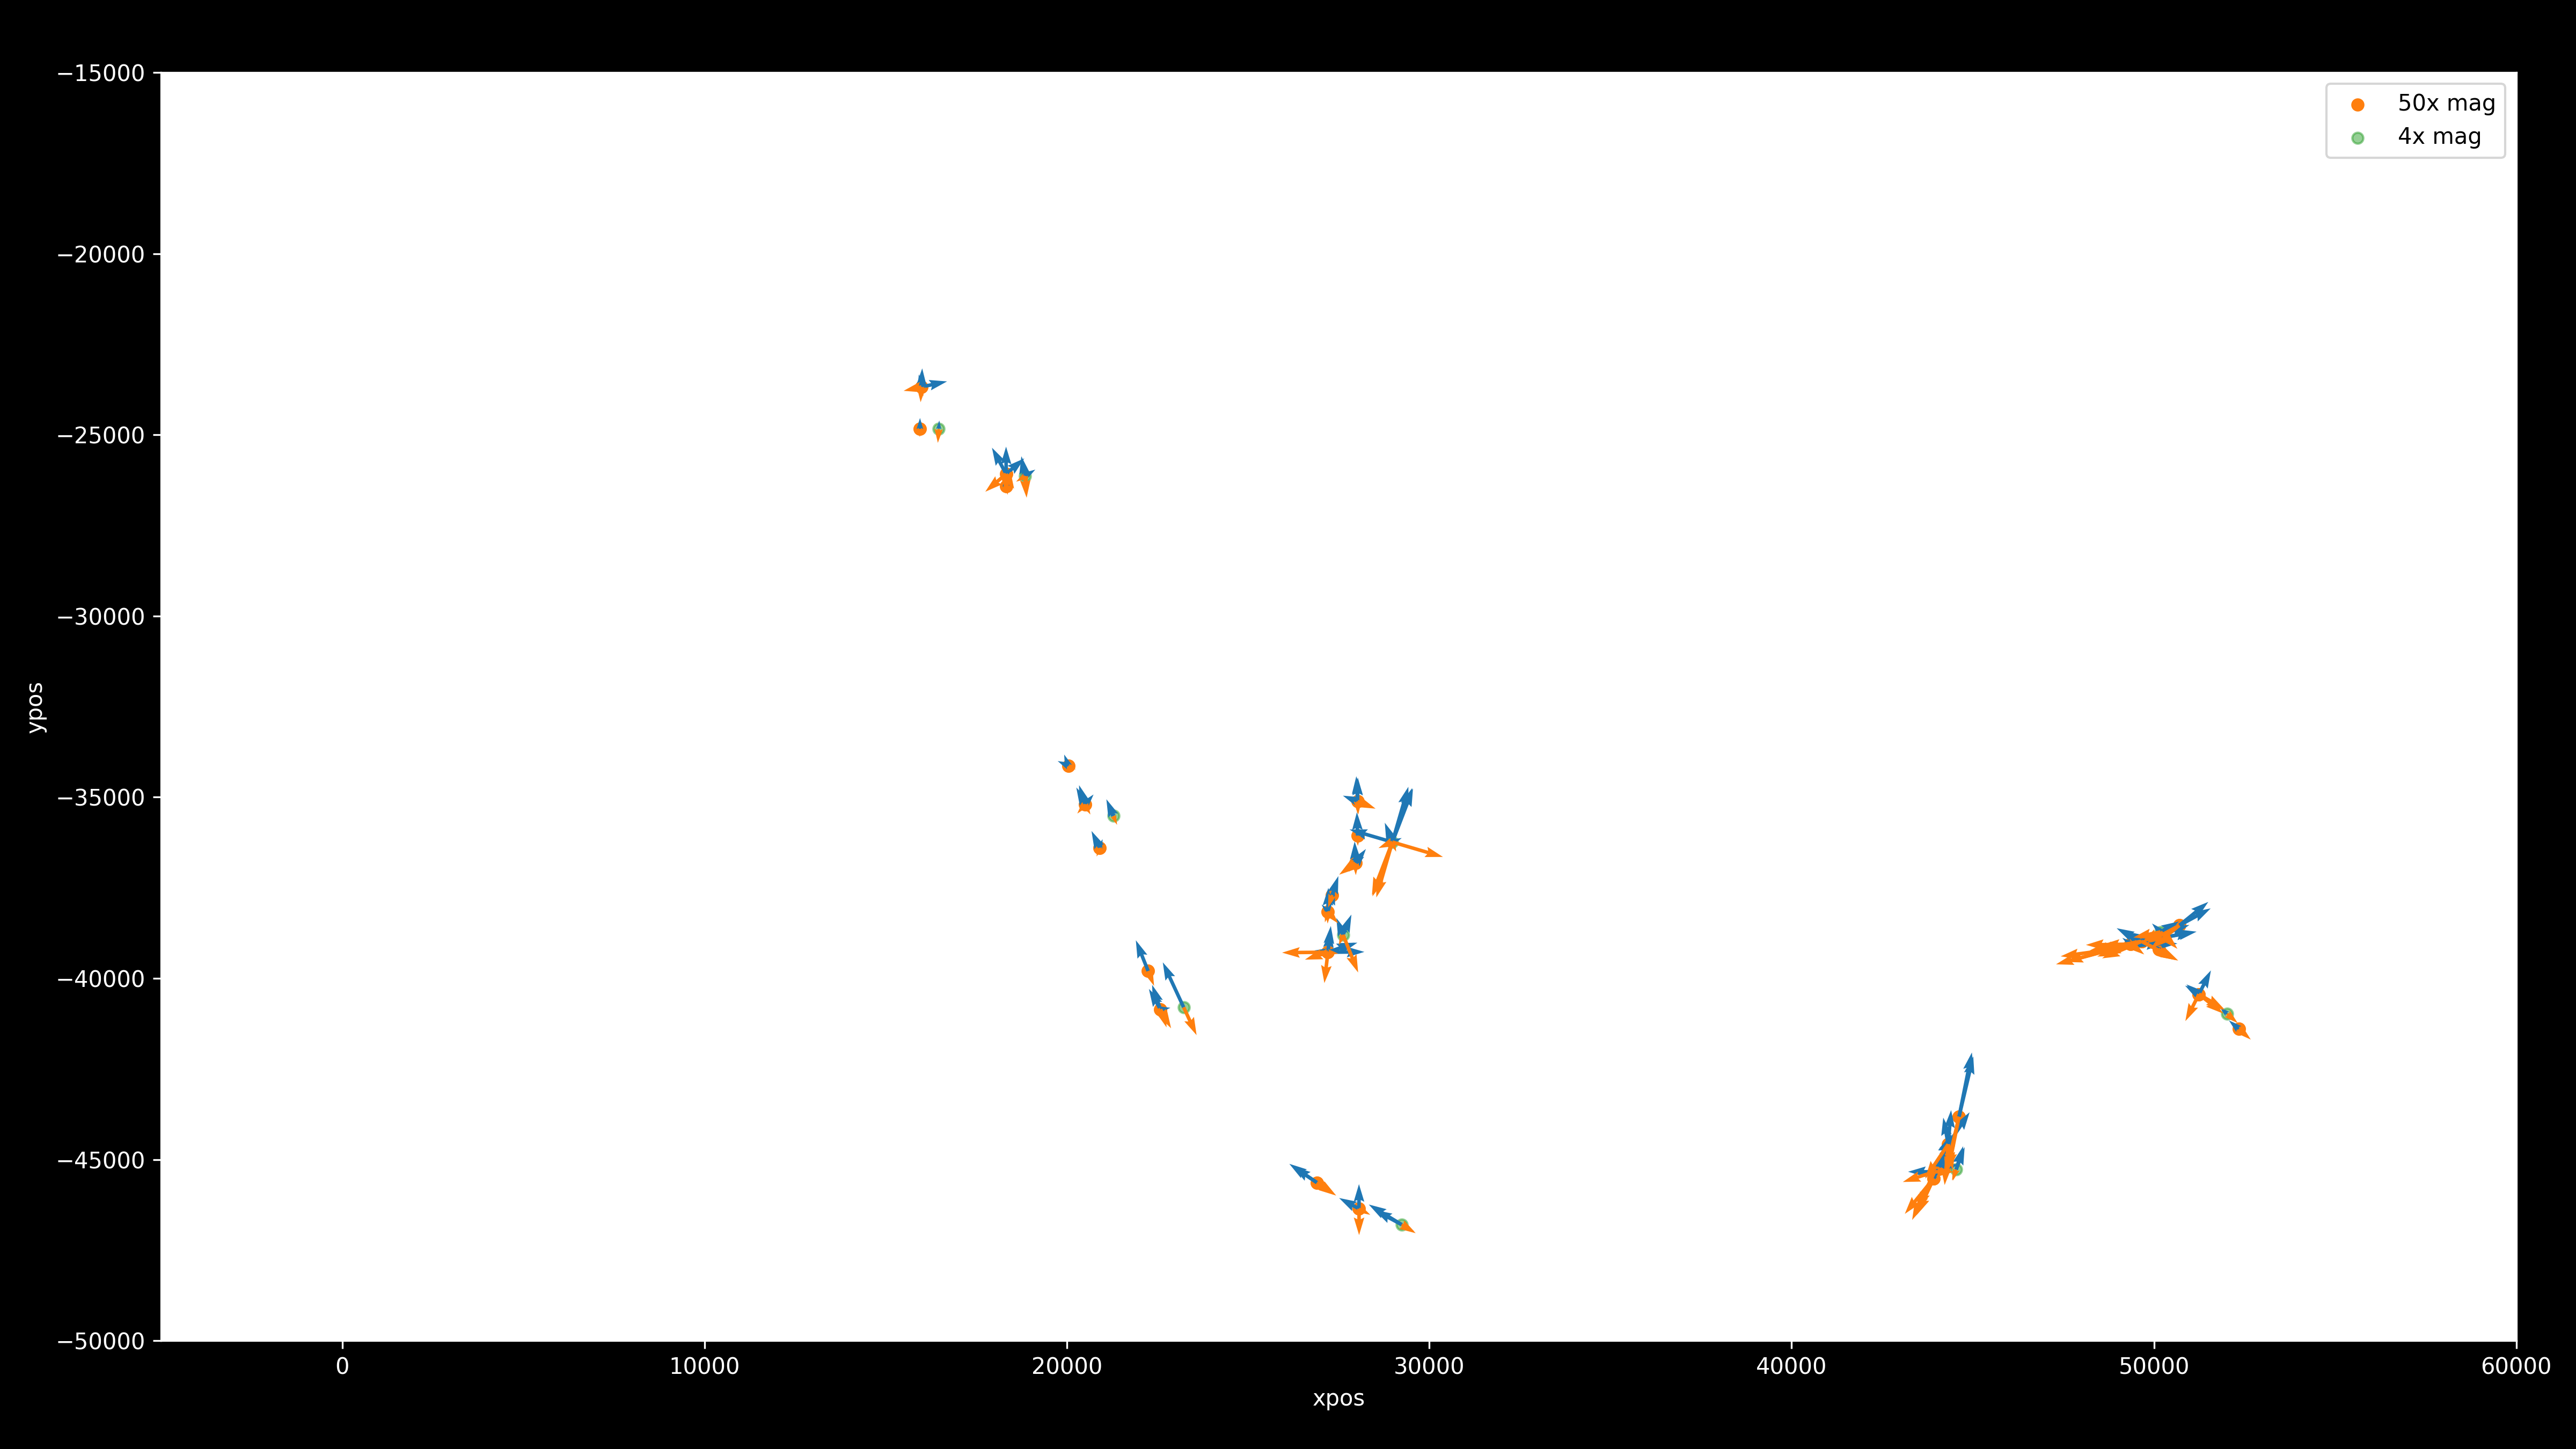

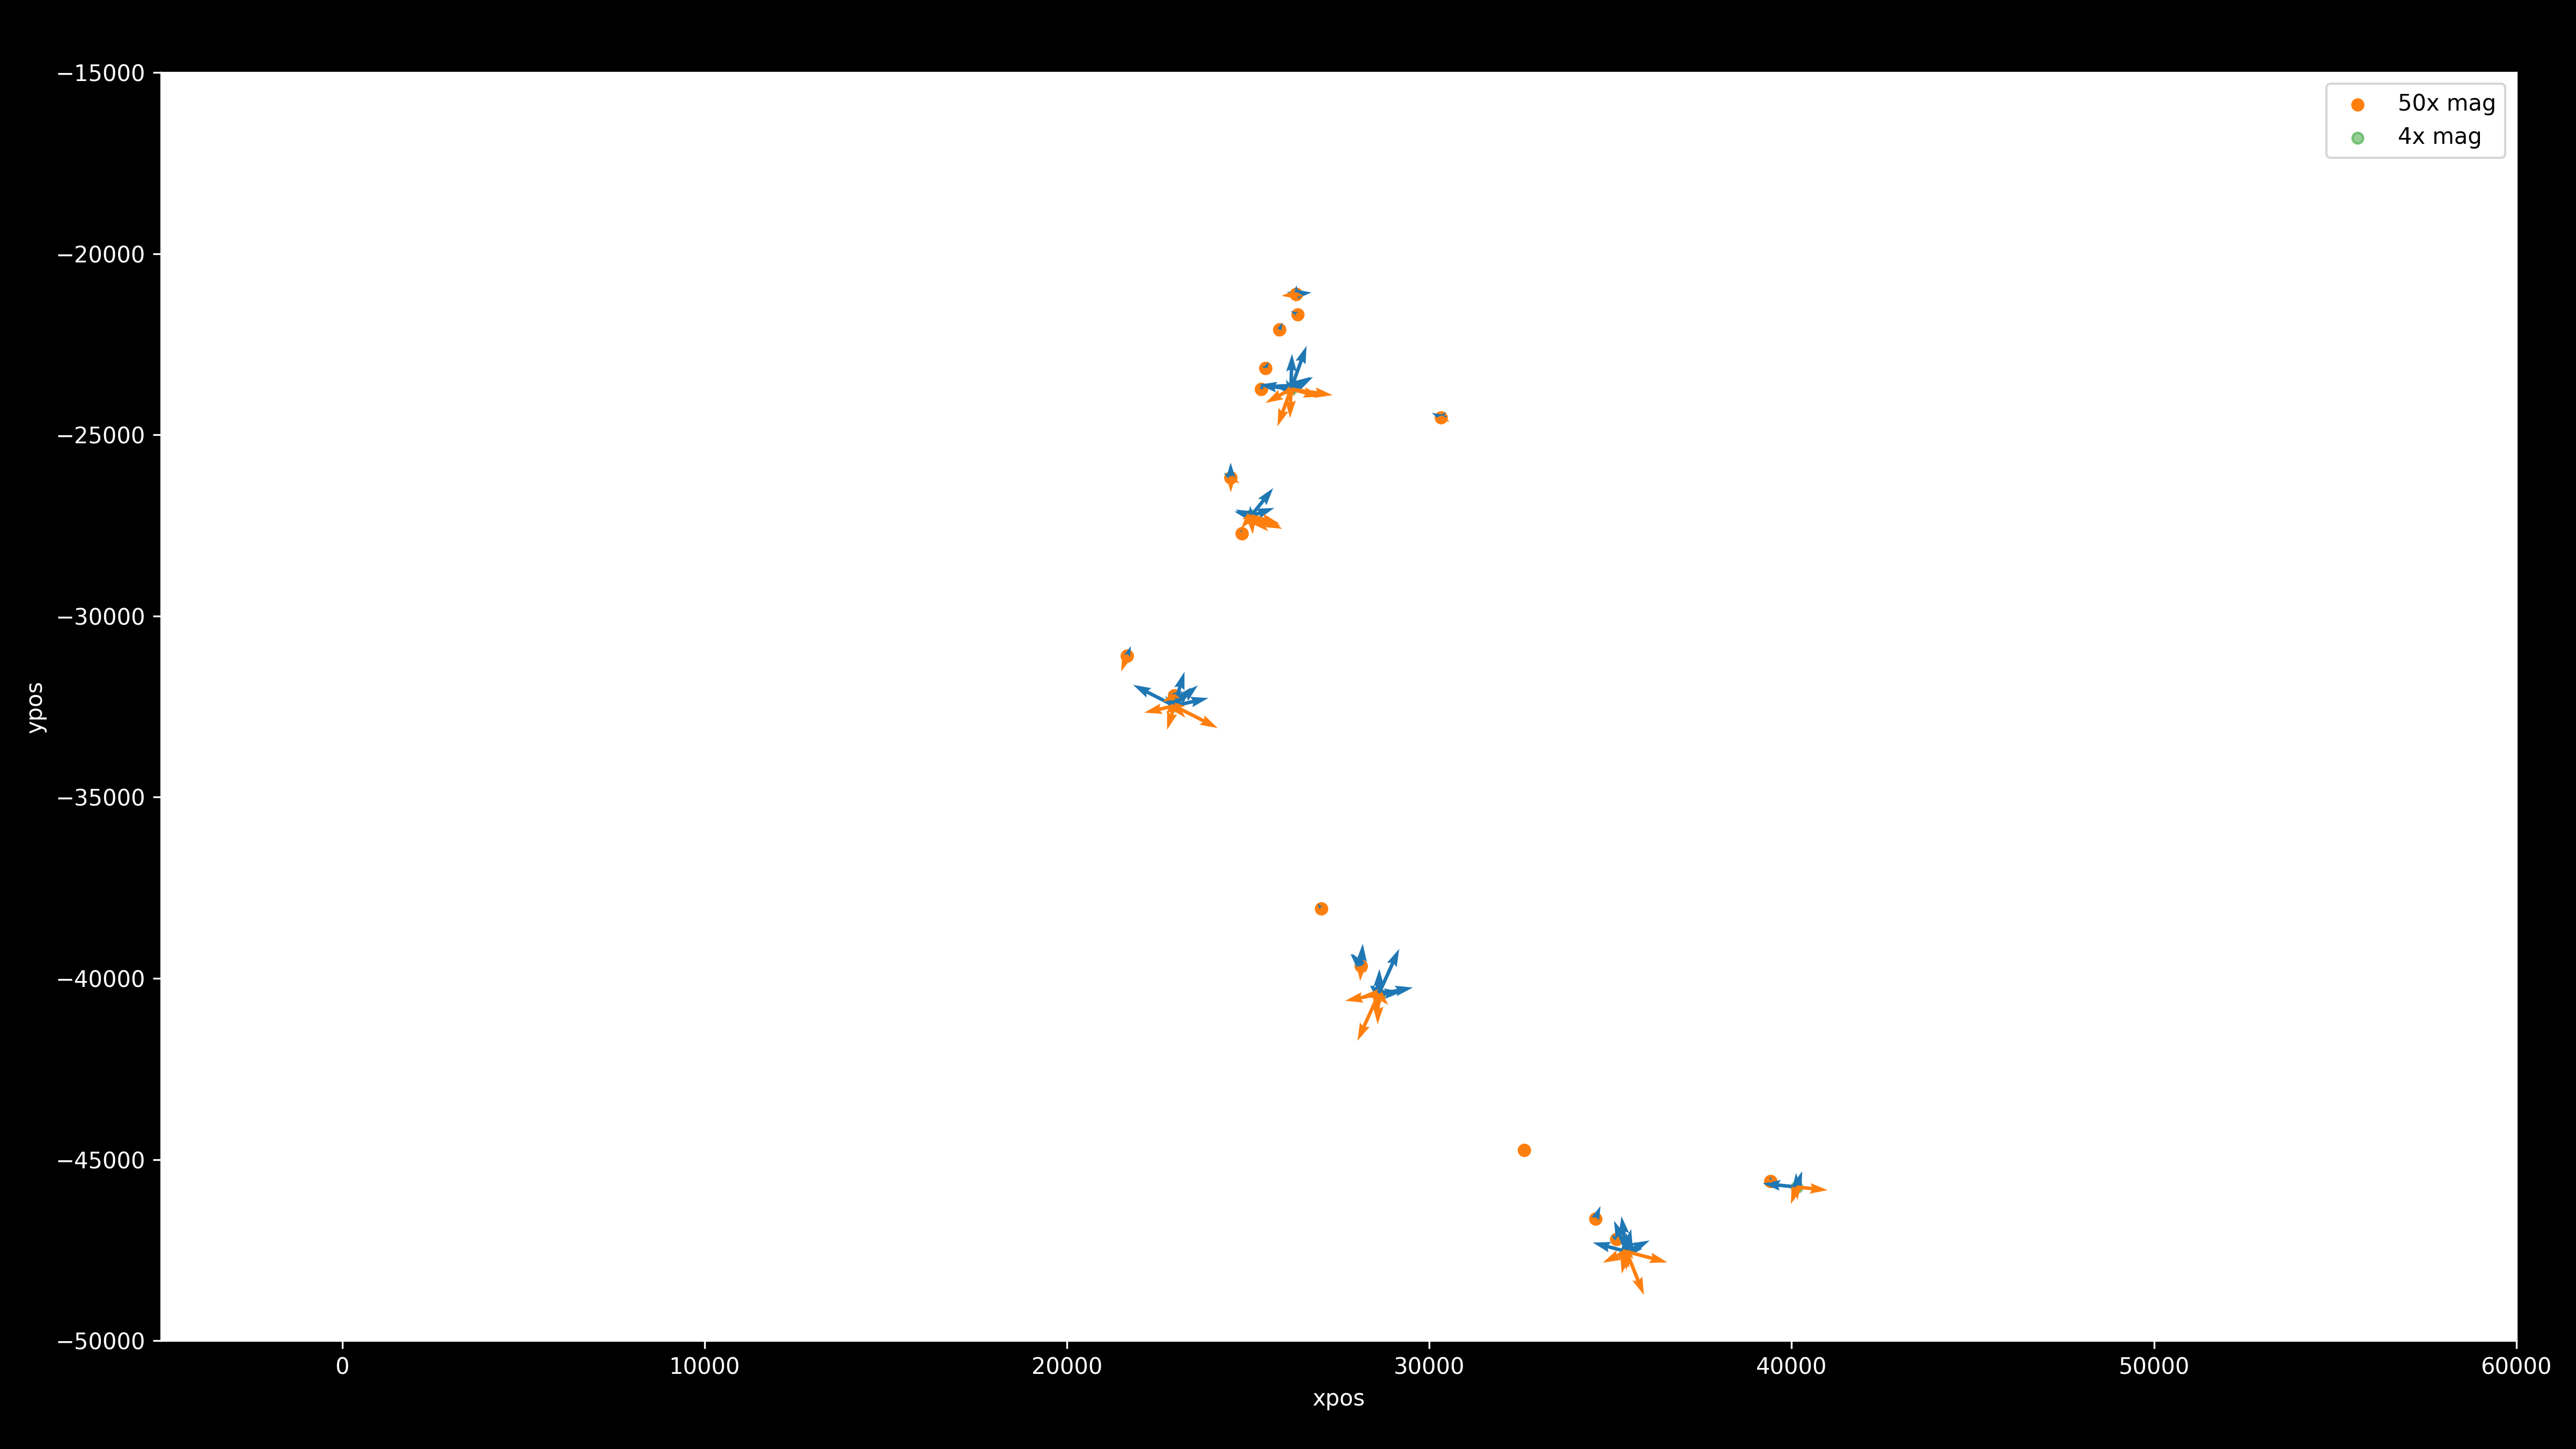

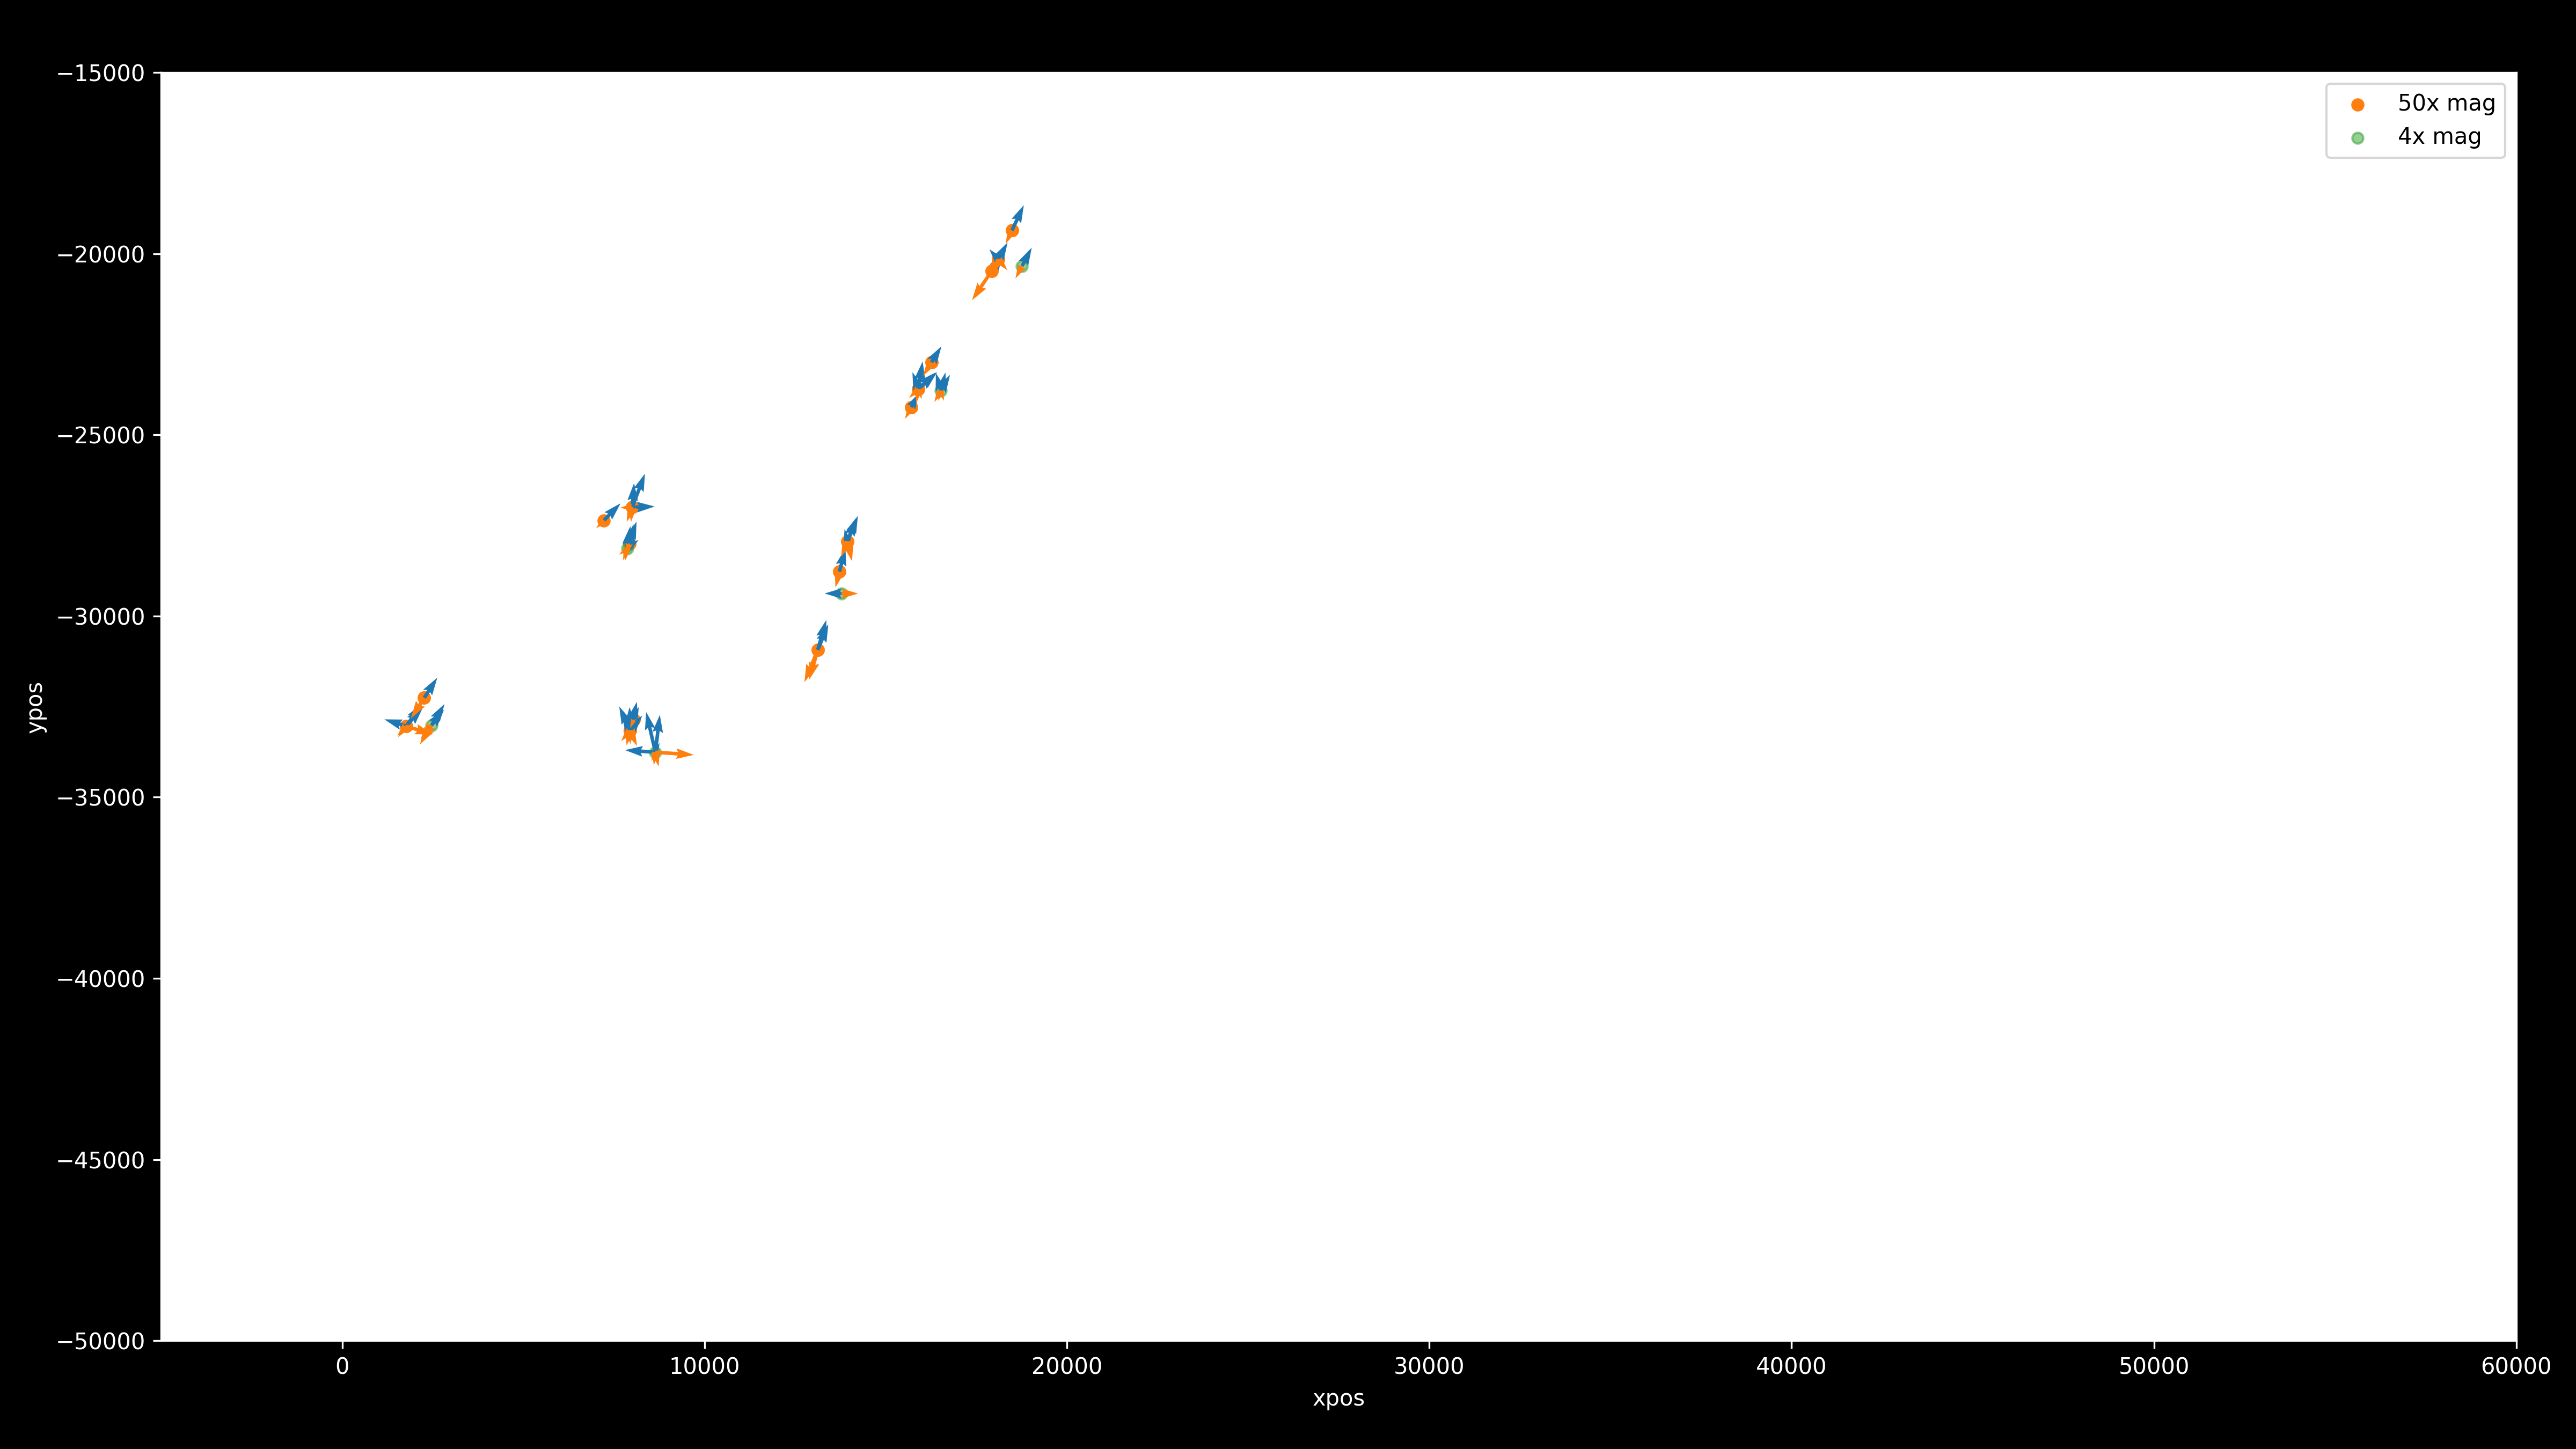

In [23]:


for plate_nr in videos_data['Plate_nr'].unique():
# plate_nr = 452

    videos_filt = videos_data[videos_data['Plate_nr'] == plate_nr]
    edges_filt = edges_data[edges_data['Plate_nr'] == plate_nr]
    edges_filt = edges_filt[edges_filt['mode'] == "F"]
#     edges_filt = edges_filt[edges_filt['mag'] == 50]
    arr_lengths_r = np.arctan(edges_filt['speed_right'] / 10) * 6.5
    arr_lengths_l = np.arctan(edges_filt['speed_left'] / 10) * 6.5

    edge_ori_x = edges_filt['edge_xpos_2'] - edges_filt['edge_xpos_1']
    edge_ori_y = edges_filt['edge_ypos_2'] - edges_filt['edge_ypos_1']
    edge_ori_theta = -np.arctan2(edge_ori_x, edge_ori_y)
    # print(np.array(edge_ori_theta))

    xpos_4 = videos_filt["xpos"][videos_filt["mag"] == 4]
    ypos_4 = -videos_filt["ypos"][videos_filt["mag"] == 4]

    xpos_50 = videos_filt["xpos"][videos_filt["mag"] == 50]
    ypos_50 = -videos_filt["ypos"][videos_filt["mag"] == 50]

    # theta = np.linspace(0, 2*np.pi, 41, endpoint=True)
    # radii, bin_edges = np.histogram(np.array(edge_ori_theta), bins=theta)
    # width = (2*np.pi) / 41

    # fig2 = plt.figure(facecolor='black')
    # ax2 = plt.subplot(111, polar=True)
    # bars = ax2.bar(theta[:-1], radii, width=width, bottom=50)
    # ax2.set_title("Orientation histogram", c='w')

    fig, ax = plt.subplots(figsize=(16, 9), facecolor='black')
    ax.scatter(xpos_50, ypos_50, c='tab:orange', s=2*12, label='50x mag')
    ax.scatter(xpos_4, ypos_4, c='tab:green', s=2*12, label='4x mag', alpha=0.5)

    ax.quiver(edges_filt['xpos'], -edges_filt['ypos'], 
              arr_lengths_r*np.cos(edge_ori_theta), 
              arr_lengths_r*np.sin(edge_ori_theta),
              scale=300, width=0.0015, alpha=1.0, color='tab:blue')
    ax.quiver(edges_filt['xpos'], -edges_filt['ypos'], 
              arr_lengths_l*np.cos(edge_ori_theta), 
              arr_lengths_l*np.sin(edge_ori_theta),
              scale=300, width=0.0015, alpha=1.0, color='tab:orange')

    ax.legend()
    ax.set_title(f"Fluorescence videos bi-directional velocity of {plate_nr}")
    ax.set_xlim((-5000, 60000))
    ax.set_ylim([-50000, -15000])
    ax.set_aspect('equal')
    ax.set_ylabel("ypos", c='w')
    ax.set_xlabel("xpos", c='w')
    fig.tight_layout()
    fig.savefig(f"/gpfs/home6/svstaalduine/plot_outs/plate_{plate_nr}_vidposs.png", transparent=True)

[(18181.818, 21363.636], (21363.636, 24545.455], (24545.455, 27727.273], (27727.273, 30909.091], (30909.091, 34090.909], (34090.909, 37272.727], (37272.727, 40454.545], (40454.545, 43636.364], (43636.364, 46818.182], (46818.182, 50000.0]]
Categories (11, interval[float64, right]): [(15000.0, 18181.818] < (18181.818, 21363.636] < (21363.636, 24545.455] < (24545.455, 27727.273] ... (37272.727, 40454.545] < (40454.545, 43636.364] < (43636.364, 46818.182] < (46818.182, 50000.0]]
[18, 40, 36, 41, 66, 115, 133, 198, 215, 15]


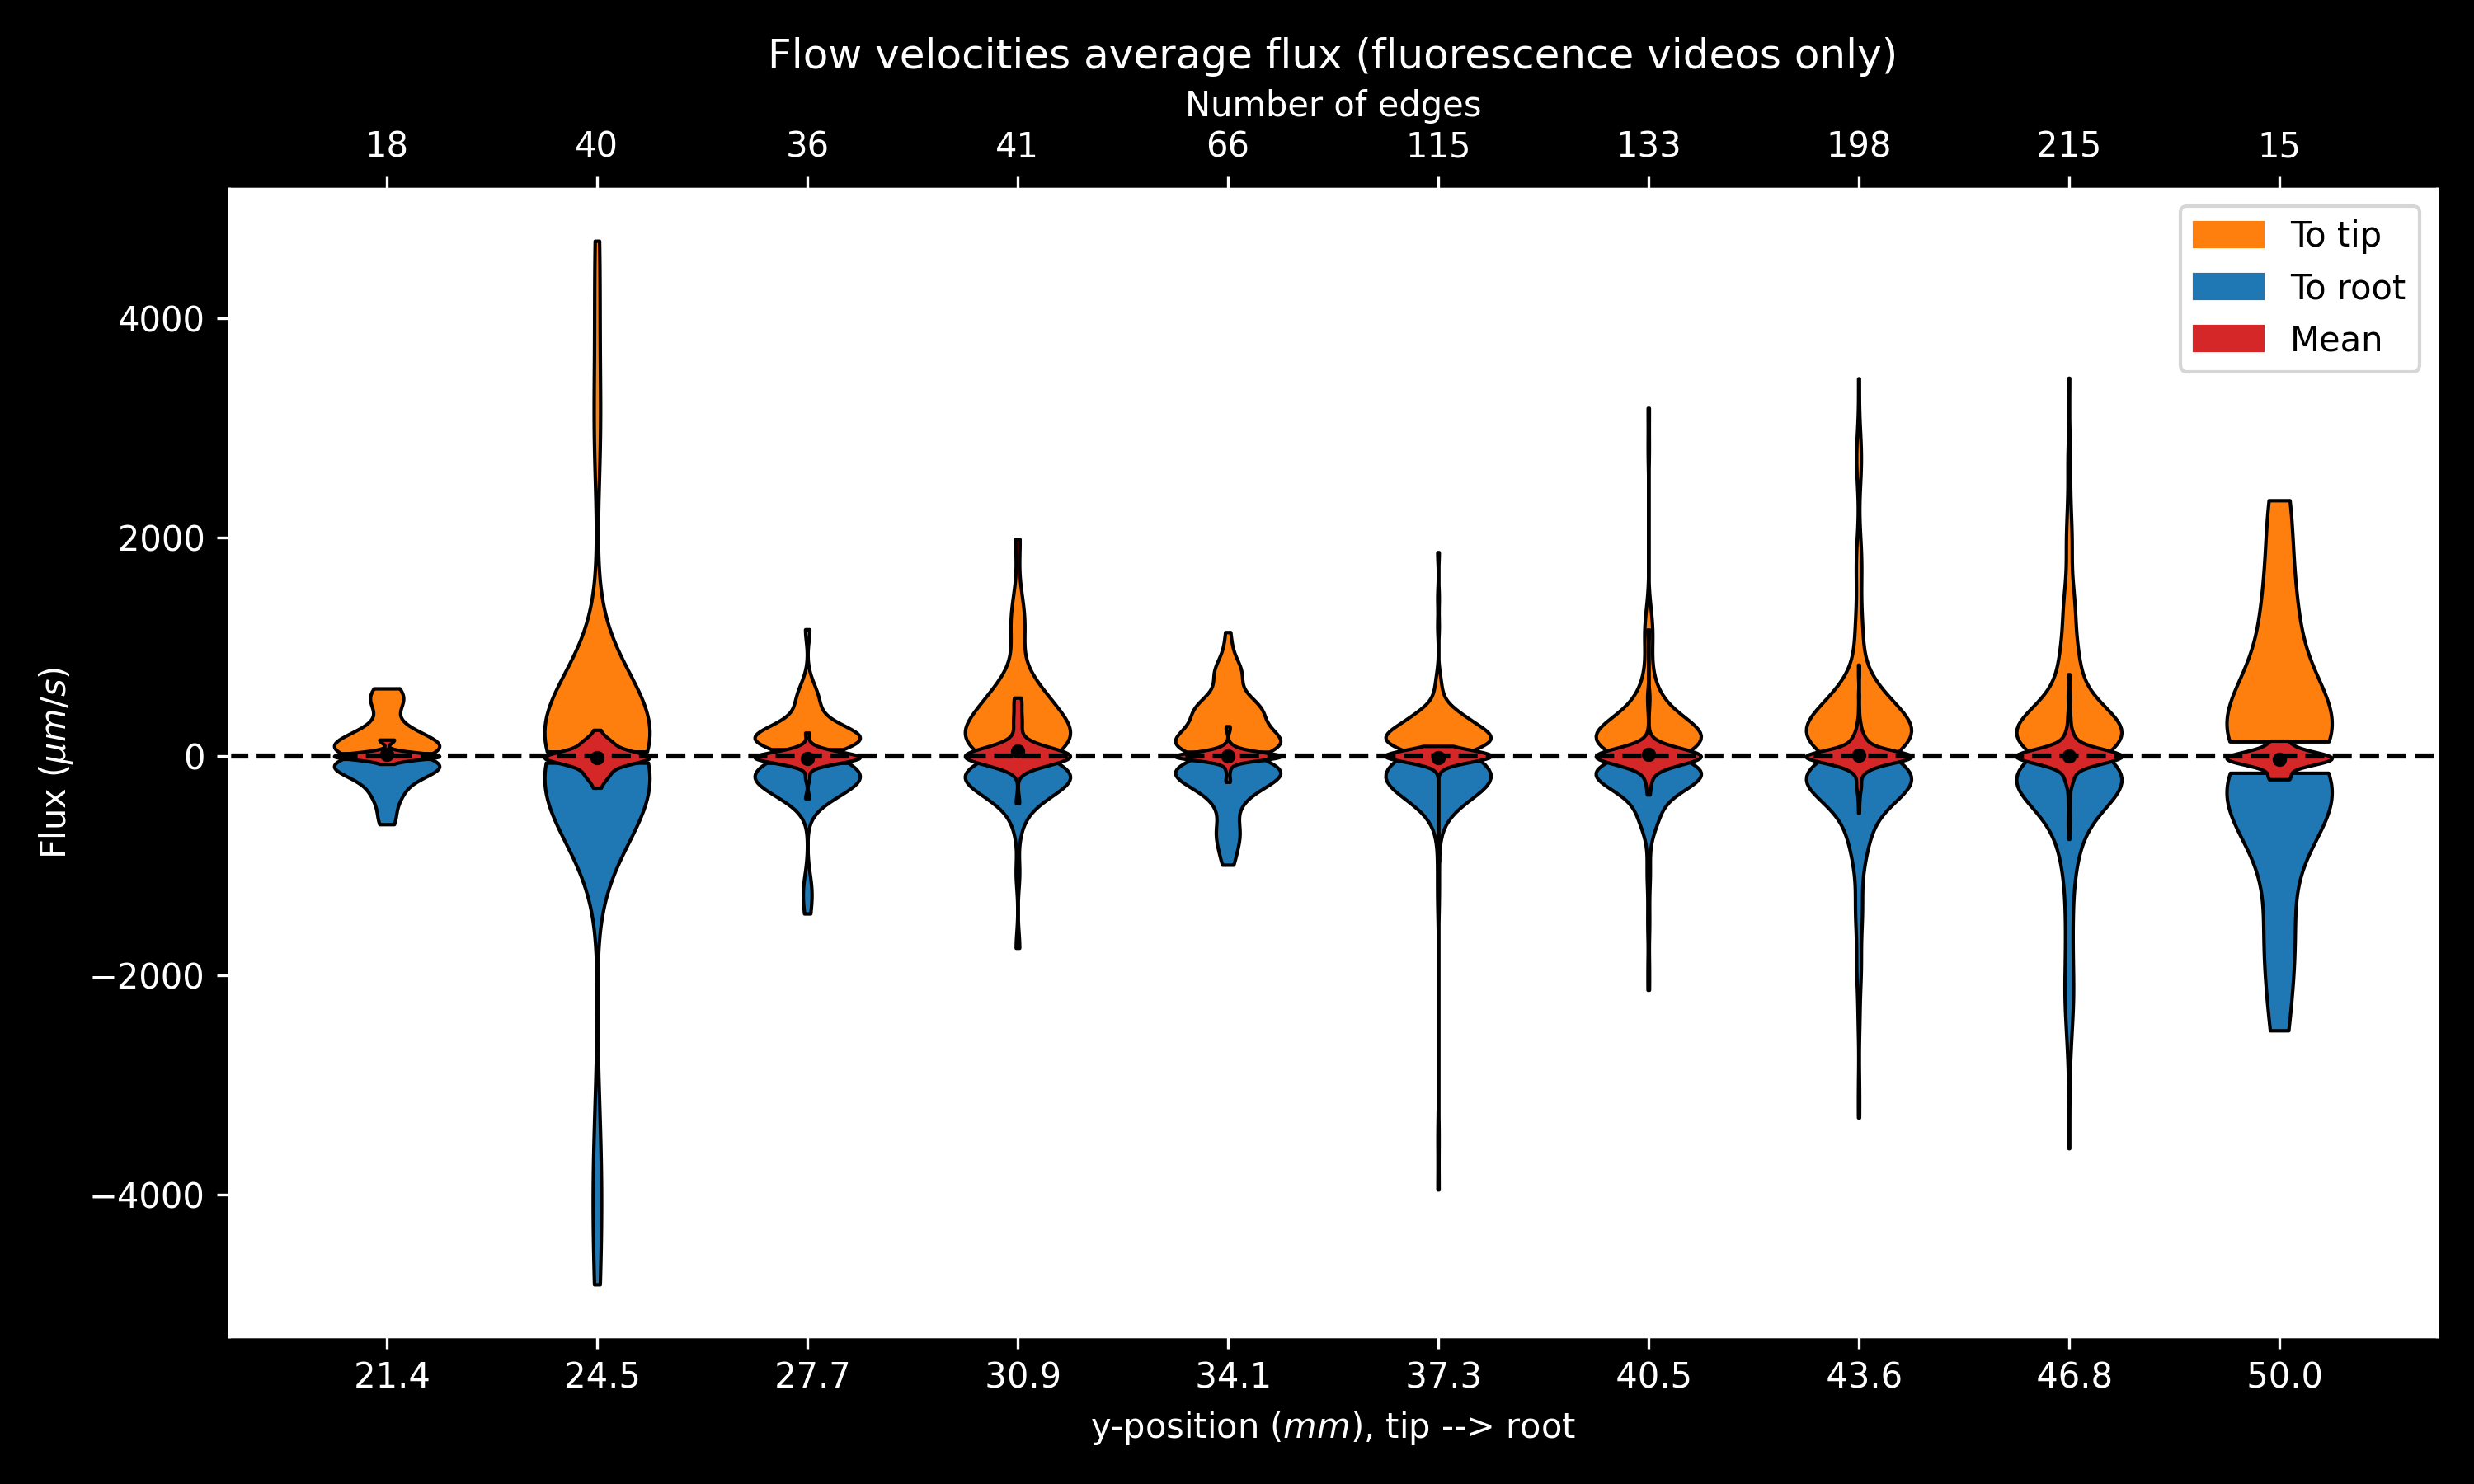

In [118]:
import matplotlib.patches as mpatches

forw=True
back=True
mean=True

labels = []
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')
    
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

# [452 462 510 537 530 545 532 527 528 552 558] are the plate numbers
plate_interest= None

edges_cov = edges_data[edges_data['coverage_tot'].ge(cov_thresh)]
edges_cov = edges_cov[edges_cov['mode'] == 'BF']
if plate_interest is not None:
    edges_cov = edges_cov[edges_cov['Plate_nr'] == plate_interest]

# width_bins = [0, 4, 5,6,7,8,9,10, 11, 12, 13]
width_bins = np.linspace(15000, 50000, 12)
edges_cov['Binned'] = pd.cut(edges_cov['ypos'], width_bins)
edges_binned = edges_cov.sort_values(by=['Binned'])
plate_ages = edges_binned['Binned'].unique()
bin_lens = []
print(plate_ages)

fig, ax = plt.subplots(facecolor='black', figsize=(10, 6))
if forw:
    spd_list_forw = []
    for age in plate_ages:
        edges_filt = edges_cov[edges_cov['Binned'] == age]
        edges_filt = edges_filt.fillna(0)
        spd_list_forw.append(np.array(edges_filt['flux_max']))
    parts = ax.violinplot(spd_list_forw, showmeans=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor('tab:orange')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    add_label(parts, 'To tip')
    
if back:
    spd_list_back = []
    for age in plate_ages:
        edges_filt = edges_cov[edges_cov['Binned'] == age]
        edges_filt = edges_filt.fillna(0)
        spd_list_back.append(np.array(edges_filt['flux_min']))
    parts = ax.violinplot(spd_list_back, showmeans=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor('tab:blue')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    add_label(parts, 'To root')

if mean:
    spd_list_mean = []
    for age in plate_ages:
        edges_filt = edges_cov[edges_cov['Binned'] == age]
        edges_filt = edges_filt.fillna(0)
        spd_list_mean.append(np.array(edges_filt['flux_avg']))
        bin_lens.append(len(edges_filt))
    print(bin_lens)
    parts = ax.violinplot(spd_list_mean, showmeans=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor('tab:red')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    add_label(parts, 'Mean')

ax.axhline(c='black', linestyle='--')
    
means = np.array([(i, np.mean(spds)) for i, spds in enumerate(spd_list_mean)]).T

mean_ax = ax.scatter(means[0]+1, means[1], c='black', s=10, label='mean')
ax.legend(*zip(*labels))
plate_ages = [f"{width.right / 1000 : 0.3}" for width in plate_ages]


set_axis_style(ax, plate_ages)
ax.set_ylabel("Flux $(\mu m / s)$", c='w')
# ax.set_xlabel("width $(\mu m)$", c='w')
ax.set_xlabel("y-position $(mm)$, tip --> root", c='w')
# ax.set_ylim([-35, 35])
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(len(bin_lens)) + 1)
ax2.set_xticklabels(bin_lens)
ax2.set_xlabel("Number of edges", c='w')
ax.set_title("Flow velocities average flux (fluorescence videos only)", c='w')
fig.tight_layout()


## 50x and 4x comparisons

First we filter out many edges with no coverage

In [7]:

videos_filt = videos_data[videos_data['mag'] == 4]
videos_filt.index = range(len(videos_filt))
# edges_filt = edges_filt[edges_filt['coverage_tot'] > 0.5]
# edges_filt = edges_filt[edges_filt['coverage_left'] > 0.7]
# edges_filt = edges_filt[edges_filt['speed_right_std'] < 0.5]
# edges_filt['speed_range'] = edges_filt['speed_right'] - edges_filt['speed_left']
# edges_filt = edges_filt[edges_filt['speed_range'] > 6]

print(videos_filt.columns)
# print(edges_filt['edge_name_r'])
videos_filt

Index(['video_title', 'Treatment', 'Strain', 'days_old', 'grow_temp', 'xpos',
       'ypos', 'dcenter mm', 'droot mm', 'mode', 'mag', 'fps', 'Comments',
       'binning', 'vid_len', 'Plate_nr', 'Address', 'space_res', 'nr_of_edges',
       'coords'],
      dtype='object')


video_title Treatment Strain  days_old  grow_temp   xpos   ypos  \
0    20221026_plate452_16  1%P100&N     C2        10       25.0  11060  46280   
1    20221026_plate452_24  1%P100&N     C2        10       25.0  13960  44040   
2    20221026_plate452_35  1%P100&N     C2        10       25.0   7460  39680   
3    20221026_plate452_43  1%P100&N     C2        10       25.0  11260  42720   
4    20221026_plate452_55  1%P100&N     C2        10       25.0   7520  42860   
..                    ...       ...    ...       ...        ...    ...    ...   
98   20230201_Plate558_13  1%P100%N     C2        23       25.0  55740  44420   
99   20230201_Plate558_22  1%P100%N     C2        23       25.0  61140  35260   
100  20230201_Plate558_27  1%P100%N     C2        23       25.0  39140  43760   
101  20230201_Plate558_32  1%P100%N     C2        23       25.0  36980  28300   
102  20230201_Plate558_39  1%P100%N     C2        23       25.0  34220  22480   

     dcenter mm  droot mm mode  mag  fps  \
0         -33.0      -3.0    F    4   10   
1         -30.0      -1.0    F    4   10   
2         -37.0       4.0    F    4   10   
3         -33.0       1.0    F    4   10   
4         -36.0       0.0    F    4   10   
..          ...       ...  ...  ...  ...   
98         12.0      -1.0    F    4   10   
99         17.0       8.0    F    4   10   
100        -5.0       0.0    F    4   10   
101        -7.0      15.0    F    4   10   
102       -10.0      21.0    F    4   10   

                                              Comments binning  vid_len  \
0      SET 1\n30 seconds. Part of network out of focus       1      NaN   
1                                    SET 2\n30 seconds       1      NaN   
2             SET 3\n60 seconds. Can see flow movement       1      NaN   
3    SET 4\nGood FOV, can see different hyphae in f...       1      NaN   
4                                    SET 6\n60 seconds       1      NaN   
..                                                 ...     ...      ...   
98                                                 NaN       2     60.0   
99                                                 NaN       2     60.0   
100                                                NaN       2     60.0   
101                                                NaN       2     60.0   
102                                                NaN       2     60.0   

     Plate_nr                                            Address space_res  \
0         452  /gpfs/scratch1/shared/amftrackflow/Rachael_set...    0.8625   
1         452  /gpfs/scratch1/shared/amftrackflow/Rachael_set...    0.8625   
2         452  /gpfs/scratch1/shared/amftrackflow/Rachael_set...    0.8625   
3         452  /gpfs/scratch1/shared/amftrackflow/Rachael_set...    0.8625   
4         452  /gpfs/scratch1/shared/amftrackflow/Rachael_set...    0.8625   
..        ...                                                ...       ...   
98        558  /gpfs/scratch1/shared/amftrackflow/Rachael_set...     1.725   
99        558  /gpfs/scratch1/shared/amftrackflow/Rachael_set...     1.725   
100       558  /gpfs/scratch1/shared/amftrackflow/Rachael_set...     1.725   
101       558  /gpfs/scratch1/shared/amftrackflow/Rachael_set...     1.725   
102       558  /gpfs/scratch1/shared/amftrackflow/Rachael_set...     1.725   

     nr_of_edges      coords  
0            3.0  1106046280  
1            3.0  1396044040  
2            1.0   746039680  
3            2.0  1126042720  
4            2.0   752042860  
..           ...         ...  
98           3.0  5574044420  
99           2.0  6114035260  
100          3.0  3914043760  
101          3.0  3698028300  
102          3.0  3422022480  

[103 rows x 20 columns]

In [8]:
video_4x_index = 43

loc_tolerance = 1000
for video_4x_index in tqdm(range(103)):
    video_data = videos_filt.iloc[video_4x_index]
    img_4x = imageio.imread(glob.glob(video_data['Address'] + "/Img/Ba*.tif*")[0])

    x_adj = 100-750+400+75
    y_adj = -500

#     print(img_4x.shape)

    edges_4x = edges_data[edges_data['Plate_nr'] == video_data['Plate_nr']]
    edges_4x = edges_4x[edges_4x['mode'] == 'F']
    edges_4x = edges_4x[edges_4x['xpos'].between(video_data['xpos']- loc_tolerance, video_data['xpos']+ loc_tolerance)]
    edges_4x = edges_4x[edges_4x['ypos'].between(video_data['ypos']- loc_tolerance, video_data['ypos']+ loc_tolerance)]

    fig, ax = plt.subplots( figsize = (16, 9), facecolor='black')
    # ax.imshow(img_4x, extent=((video_data['xpos']- img_4x.shape[1]*0.5) + x_adj, (video_data['xpos'] + img_4x.shape[1]*0.5)+x_adj, 
    #                           (-video_data['ypos']) + y_adj, (-1*(video_data['ypos'] - img_4x.shape[0]))+y_adj))
    ax.scatter(edges_4x['xpos'], -edges_4x['ypos'], label='50x video')
    ax.scatter(video_data['xpos'], -video_data['ypos'], label='4x video')

    for index, row in edges_4x.iterrows():
        if row['mag'] == 4:
            continue
        arrow_start =  np.array([(row['xpos'] + row['space_res'] *row['edge_ypos_2'], 
                        (row['ypos'] + row['space_res'] *row['edge_xpos_2'])*-1)])[0]
        arrow_end =    np.array([(row['xpos'] + row['space_res'] *row['edge_ypos_1'], 
                        (row['ypos'] + row['space_res'] *row['edge_xpos_1'])*-1)])[0] - arrow_start
        ax.quiver(arrow_start[0], arrow_start[1], arrow_end[0], arrow_end[1], angles='xy', color=['tab:green', 'gray'][row['mag'] == 50], scale_units='xy', scale=1)
    #     print(arrow_start, arrow_end)
    ax.set_xlim((video_data['xpos']- img_4x.shape[1]*0.5) + x_adj, (video_data['xpos'] + img_4x.shape[1]*0.5)+x_adj)
    ax.set_ylim((-video_data['ypos']) + y_adj, (-1*(video_data['ypos'] - img_4x.shape[0]))+y_adj)

    used_videos = [row.split('_')[-1] for row in edges_4x['video_title'].unique()]
#     print(used_videos)
    ax.set_title(f"4x overview of {video_data['video_title']}, \n with 50x videos {used_videos[1:]}", c='w')
    ax.set_aspect('equal')
    ax.legend()
    fig.tight_layout()
    fig.savefig(f"/gpfs/home6/svstaalduine/plot_outs/overviews_4x/{video_data['video_title']}_4x_overview.png", transparent=True)
    plt.close('all')
# edges_4x

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [01:37<00:00,  1.06it/s]
